<a href="https://colab.research.google.com/github/Rajaguhan437/AI-Generation_SEGmnt/blob/main/Num_Generation/code/Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
### importing libs

import torch
import pdb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [ ]:
!pip install wandb
#%pip install wandb

import wandb
wandb.login(key="95eda70b703e651a93829d62187e30b7bc107306")

In [ ]:
exp_name = wandb.util.generate_id()

myrun = wandb.init(
    project = "Num-Gen",
    group = "MNIST-NUM",
    config = {
        "optimizer" : "adam",
        "model" : "MNIST-NumGen",
        "epoch" : "1000",
        "batch_size" : 128

    }
)

config = wandb.config

In [ ]:
print(exp_name)

In [ ]:
def show(tensor, ch=1, size=(28, 28), num=16, wandbactive=0, name='Image'):
    data = tensor.detach().cpu().view(-1, ch, *size) # (batch size, channels, height, width)
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) # (num, height, width, channels)

    if  wandbactive==1 :
        wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})

    plt.imshow(grid)
    plt.show()

In [ ]:
epochs = 500
cur_step = 0
info_step = 469*5

mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64

lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

batch_size = 128
device = "cuda"

save_steps = 235*5

wandbact = 1

dataloader = DataLoader(MNIST("/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Dataset", download=True, transform=transforms.ToTensor()),batch_size=batch_size, shuffle=True)

# no. of steps = total images / batch size
# here, steps = 60000 / 256 = 234.375, took 2h 30 min for 500 epochs
# here, steps = 60000 / 128 = 468.75, took 39min for another 140 epochs



In [ ]:
def genBlock( inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)
    )

class Genrator(nn.Module):
    def __init__(self, z_dim=64, o_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64 , 128
            genBlock(h_dim, h_dim*2), # 128, 256
            genBlock(h_dim*2, h_dim*4), # 256, 512
            genBlock(h_dim*4, h_dim*8), # 512, 1024
            genBlock(h_dim*8, h_dim*8), # 1024, 1024
            nn.Linear(h_dim*8, o_dim), # 1024, 784
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device)

In [ ]:
## DiscBlock

def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        #nn.BatchNorm1d(out), ==> led to white block of pixels in fake imgs at starting itself.
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):
    def __init__(self, o_dim=784, h_dim=128):
      super().__init__()
      self.disc = nn.Sequential(
          discBlock(o_dim, h_dim*8), # 784 , 1024
          discBlock(h_dim*8, h_dim*4), # 1024, 512
          discBlock(h_dim*4, h_dim*2), # 512, 256
          discBlock(h_dim*2, h_dim), # 256, 128
          nn.Linear(h_dim, 1), # 128, 1
        )

    def forward(self, image):
        return self.disc(image)

In [ ]:
gen = Genrator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
gen

In [ ]:
disc

In [ ]:
## Weight Initialisations

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

#gen = gen.apply(init_weights)
#critic = critic.apply(init_weights)

In [ ]:
## monitoring gradients and parameters in real time

if wandbact == 1:
    wandb.watch(gen, log_freq=100)
    wandb.watch(disc, log_freq=100)

In [ ]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:20])
show(x)

In [ ]:
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
def calc_gen_loss(loss_func, gen, disc, number, z_dim):

    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)

    return gen_loss

In [ ]:
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):

    noise = gen_noise(number, z_dim)
    fake = gen(noise)

    pred_fake = disc(fake.detach())
    pred_fake_targets = torch.zeros_like(pred_fake)
    pred_fake_loss = loss_func(pred_fake, pred_fake_targets)

    pred_real = disc(real)
    pred_real_targets = torch.ones_like(pred_real)
    pred_real_loss = loss_func(pred_real, pred_real_targets)

    disc_loss = (pred_real_loss + pred_fake_loss) / 2

    return disc_loss



In [ ]:
def save_checkpoint(name, save_path):

    ## Generator model
    torch.save(
        {
        'epoch' : epoch,
        'model_state_dict' :gen.state_dict(),
        'optimizer_state_dict' : gen_opt.state_dict()
        },
        save_path+'Gen-'+name+'.pkl'
    )


    ## Discriminator Model
    torch.save(
        {
        'epoch' : epoch,
        'model_state_dict' :disc.state_dict(),
        'optimizer_state_dict' : disc_opt.state_dict()
        },
        save_path+'Disc-'+name+'.pkl'
    )

    print("Saved Checkpoint")


In [ ]:
## Load Checkpoint

def load_checkpoint(name, load_path):

    ## Load Gen
    chkpt = torch.load(load_path+'Gen-'+name+'.pkl')
    gen.load_state_dict(chkpt['model_state_dict'])
    gen_opt.load_state_dict(chkpt['optimizer_state_dict'])

    ## Load Discriminator
    chkpt = torch.load(load_path+'Disc-'+name+'.pkl')
    disc.load_state_dict(chkpt['model_state_dict'])
    disc_opt.load_state_dict(chkpt['optimizer_state_dict'])

    print('Loaded Checkpoint')

In [ ]:
# Test save and load

save_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"
load_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"

epoch = 1

save_checkpoint("test", save_path)
load_checkpoint("test", load_path)

In [ ]:
load_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"
load_checkpoint("NumGEN-MNIST", load_path)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 1175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

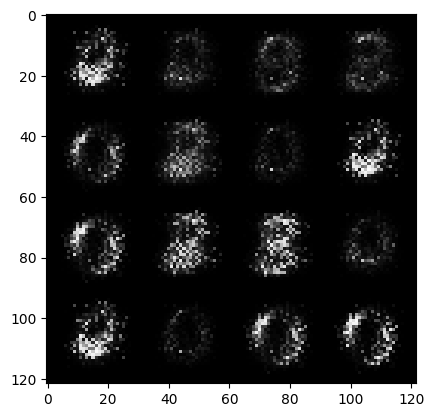

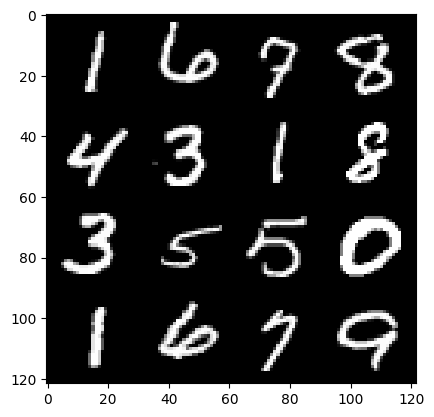

Epoch = 6 cur_step = 2345 disc_loss = 0.030973488729256492 gen_loss = 4.72824970277896
Saving Checkpoint: 2350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 3525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

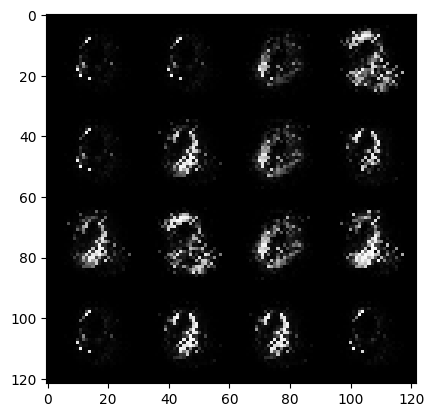

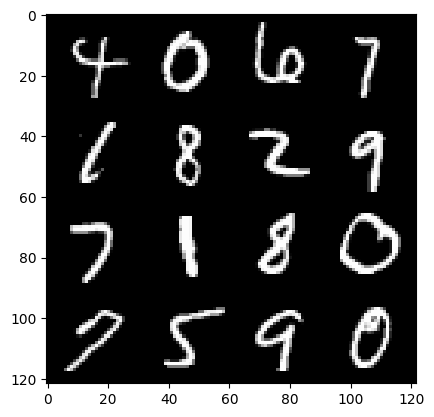

Epoch = 11 cur_step = 4690 disc_loss = 0.014194402088826177 gen_loss = 6.147724103419257
Saving Checkpoint: 4700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 5875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

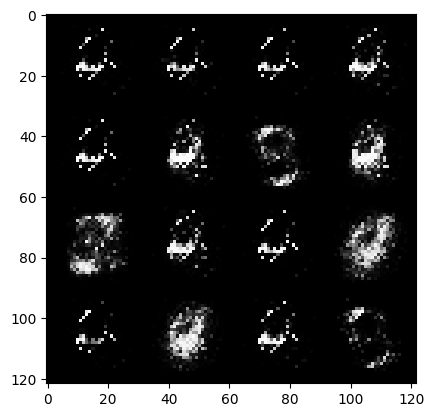

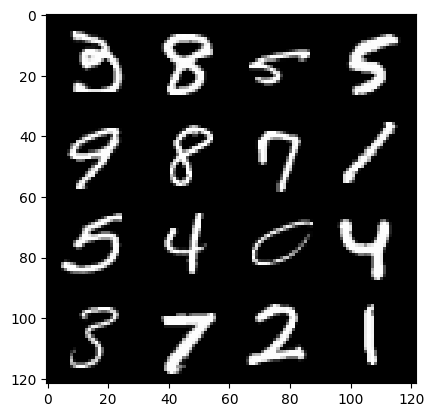

Epoch = 16 cur_step = 7035 disc_loss = 0.01423463765065124 gen_loss = 7.004081658361309
Saving Checkpoint: 7050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 8225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

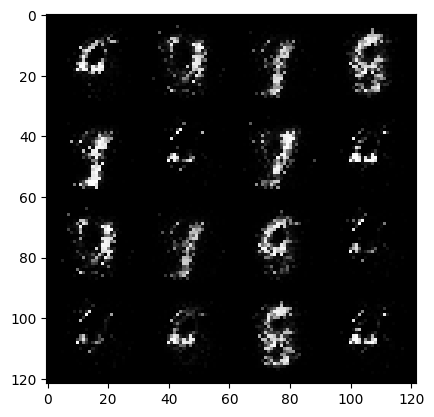

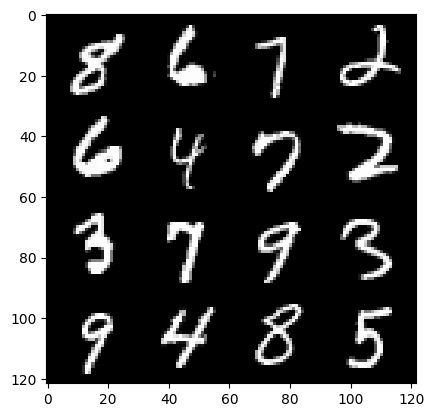

Epoch = 21 cur_step = 9380 disc_loss = 0.019767276955389185 gen_loss = 7.855670656883386
Saving Checkpoint: 9400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 10575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

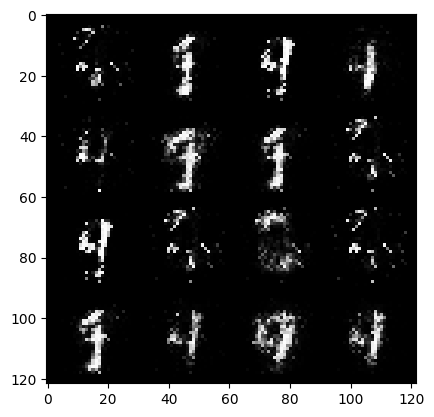

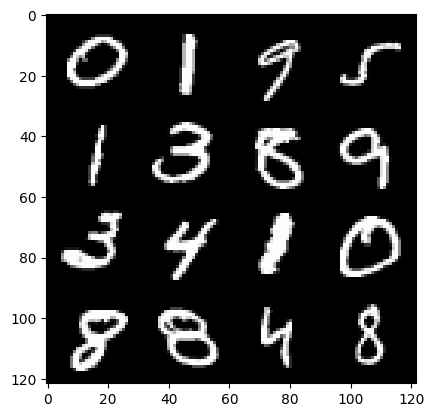

Epoch = 26 cur_step = 11725 disc_loss = 0.02938062265001015 gen_loss = 7.222759042264047
Saving Checkpoint: 11750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 12925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

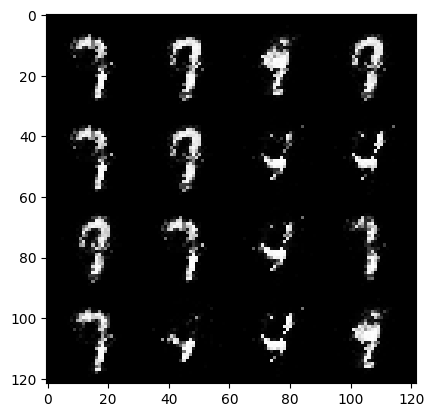

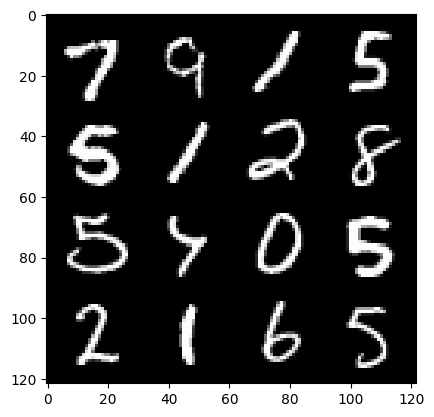

Epoch = 31 cur_step = 14070 disc_loss = 0.043344852614250265 gen_loss = 6.418124274353483
Saving Checkpoint: 14100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 15275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

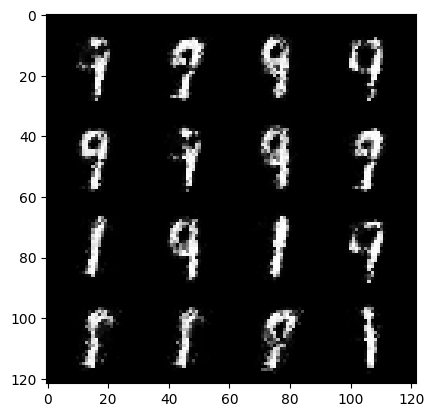

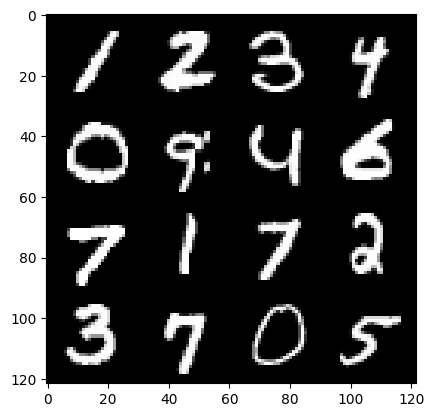

Epoch = 36 cur_step = 16415 disc_loss = 0.06728306428940375 gen_loss = 4.918948387337138
Saving Checkpoint: 16450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 17625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

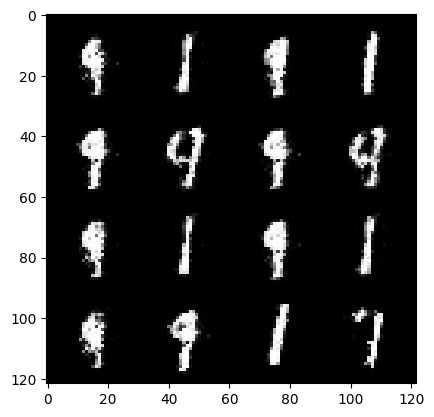

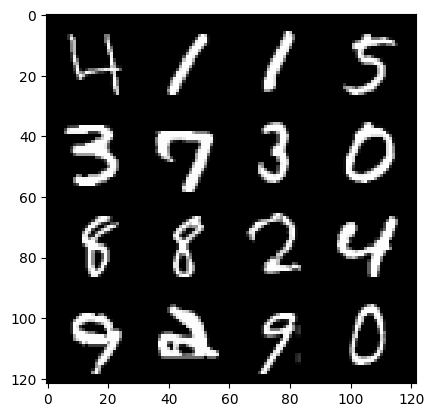

Epoch = 41 cur_step = 18760 disc_loss = 0.11569618515209602 gen_loss = 3.6530500336750737
Saving Checkpoint: 18800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 19975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

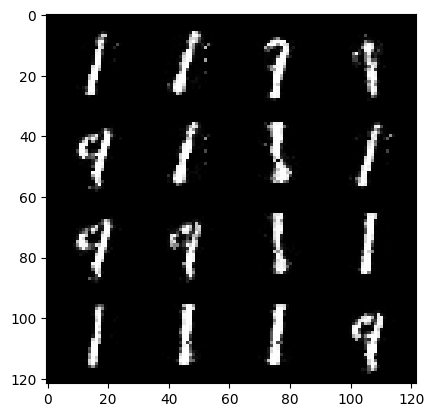

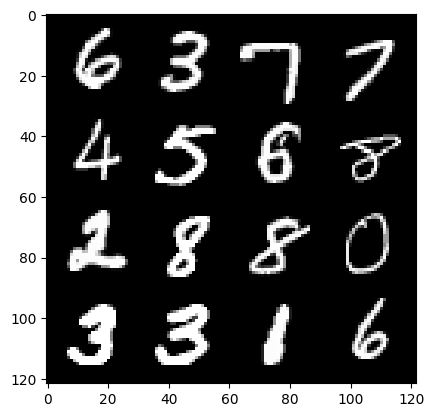

Epoch = 46 cur_step = 21105 disc_loss = 0.14785422447171293 gen_loss = 3.164568375016072
Saving Checkpoint: 21150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 22325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

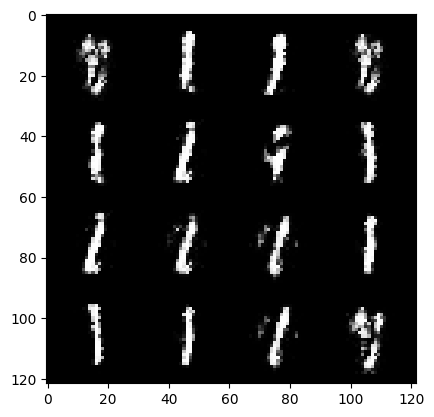

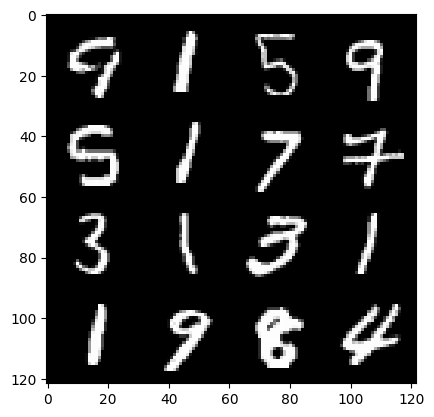

Epoch = 51 cur_step = 23450 disc_loss = 0.15943614247797142 gen_loss = 2.9041068317031047
Saving Checkpoint: 23500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 24675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

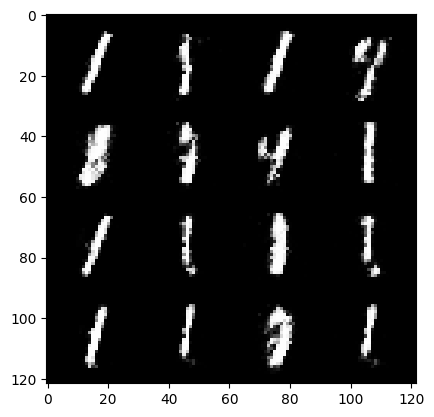

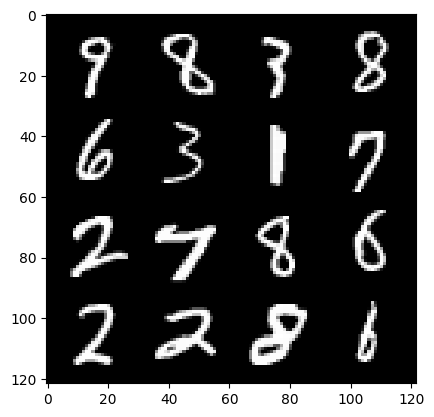

Epoch = 56 cur_step = 25795 disc_loss = 0.17502139841061412 gen_loss = 2.6946793941546603
Saving Checkpoint: 25850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 27025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

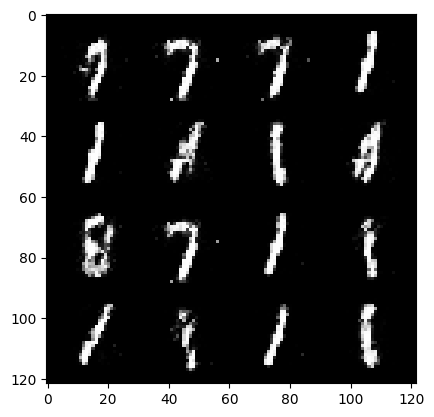

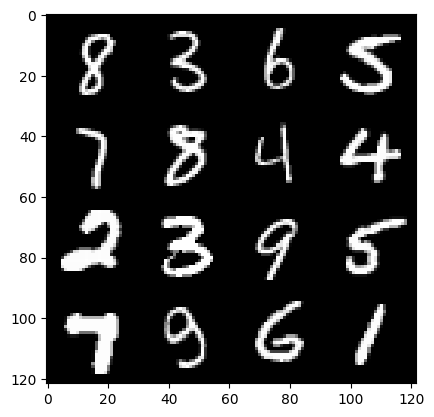

Epoch = 61 cur_step = 28140 disc_loss = 0.1854474047036059 gen_loss = 2.5255603665736186
Saving Checkpoint: 28200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 29375
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

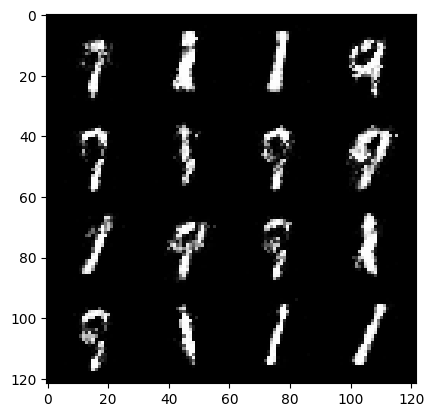

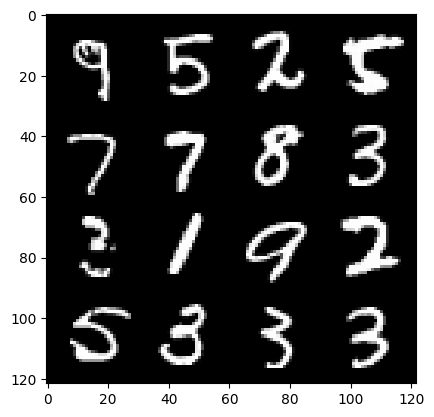

Epoch = 66 cur_step = 30485 disc_loss = 0.19768950745368055 gen_loss = 2.4139957879397915
Saving Checkpoint: 30550
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 31725
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

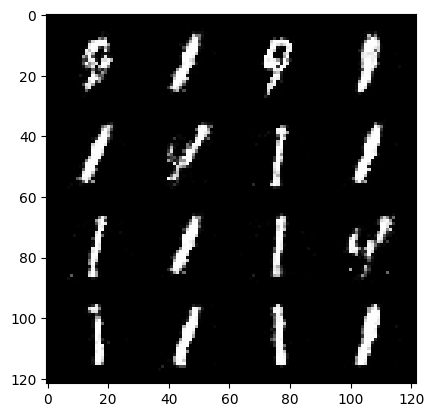

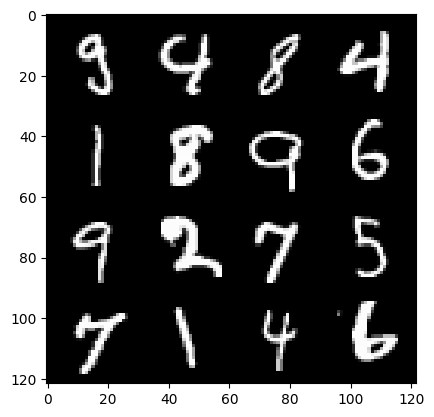

Epoch = 71 cur_step = 32830 disc_loss = 0.2020448091155939 gen_loss = 2.3630003788832155
Saving Checkpoint: 32900
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 34075
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

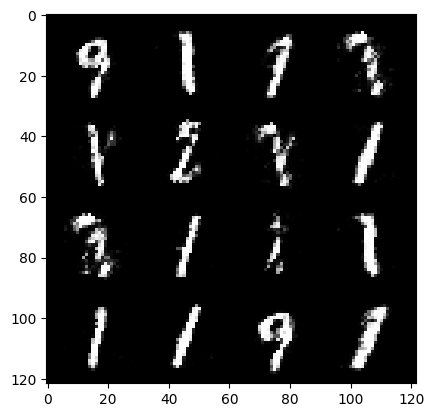

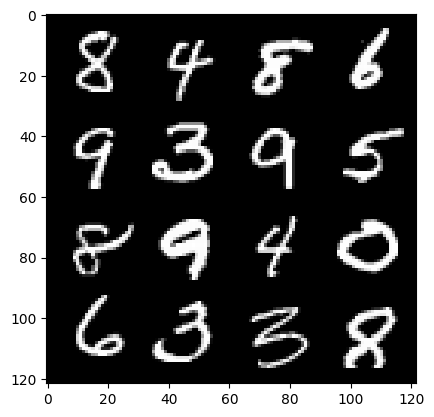

Epoch = 76 cur_step = 35175 disc_loss = 0.20996956559323043 gen_loss = 2.2855505437484935
Saving Checkpoint: 35250
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 36425
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

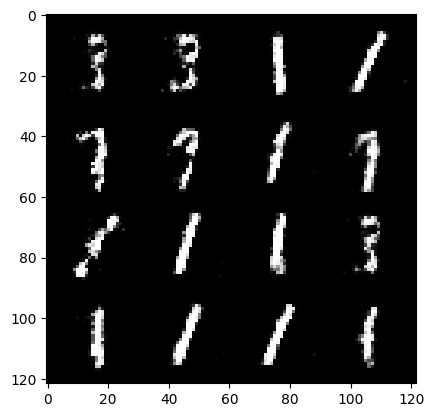

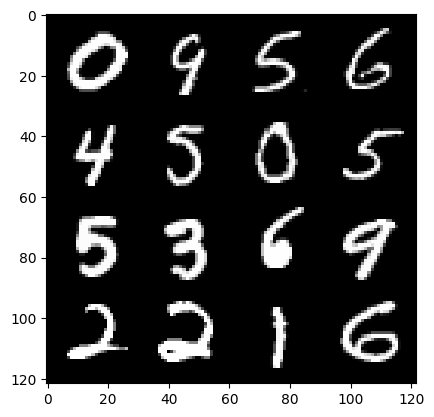

Epoch = 81 cur_step = 37520 disc_loss = 0.22910053398944677 gen_loss = 2.14449836699439
Saving Checkpoint: 37600
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 38775
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

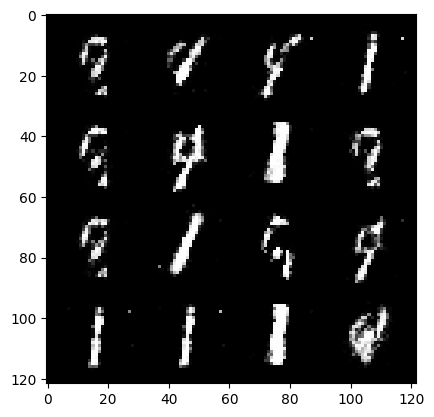

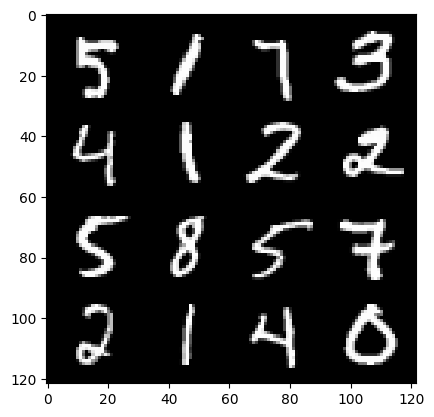

Epoch = 86 cur_step = 39865 disc_loss = 0.255009545681319 gen_loss = 2.014039470747844
Saving Checkpoint: 39950
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 41125
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

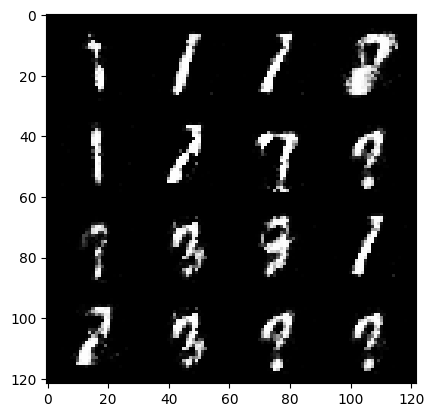

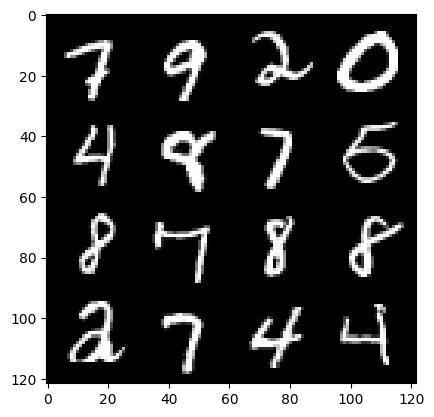

Epoch = 91 cur_step = 42210 disc_loss = 0.2646631944154117 gen_loss = 1.9382875125799606
Saving Checkpoint: 42300
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 43475
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

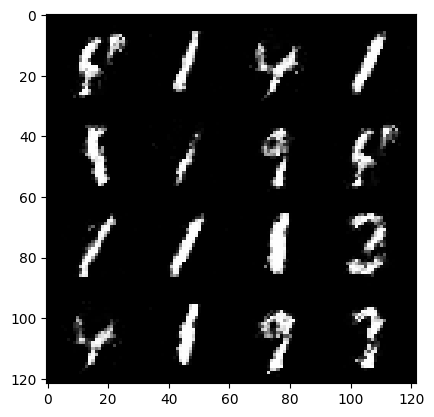

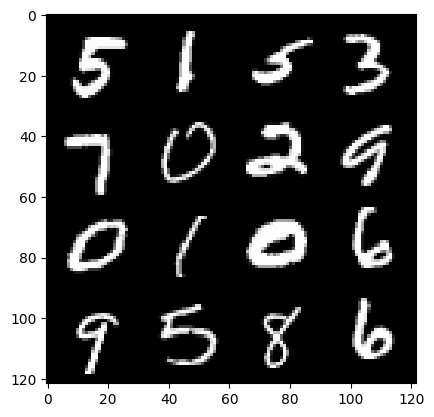

Epoch = 96 cur_step = 44555 disc_loss = 0.2551827048505547 gen_loss = 1.990437524964306
Saving Checkpoint: 44650
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 45825
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

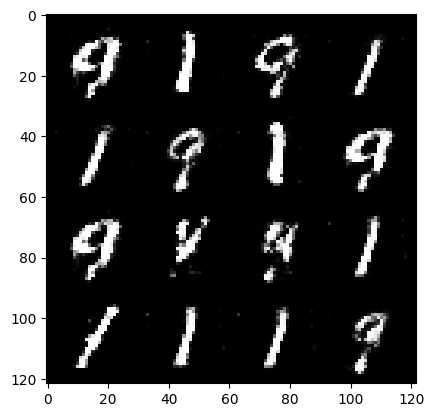

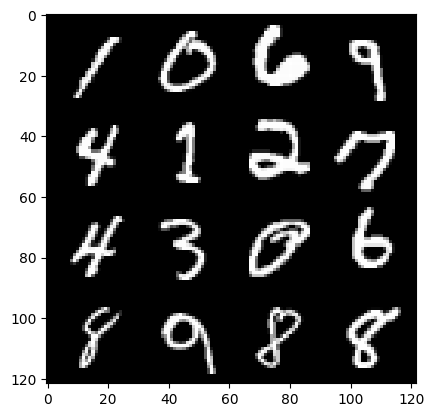

Epoch = 101 cur_step = 46900 disc_loss = 0.2856615728724486 gen_loss = 1.8477017906428908
Saving Checkpoint: 47000
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 48175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

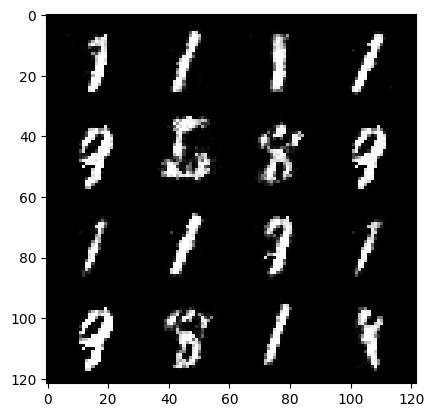

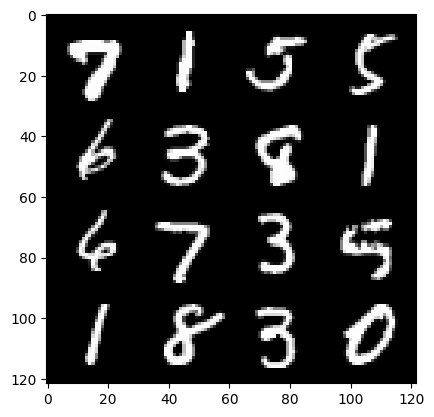

Epoch = 106 cur_step = 49245 disc_loss = 0.3208734783473045 gen_loss = 1.6811294589215504
Saving Checkpoint: 49350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 50525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

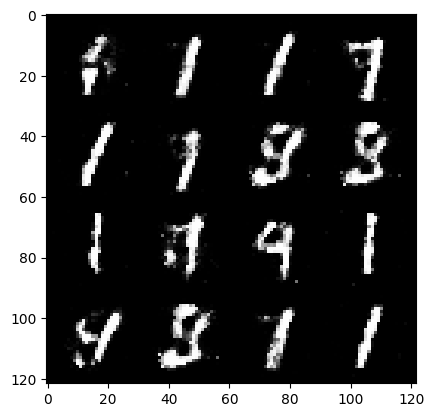

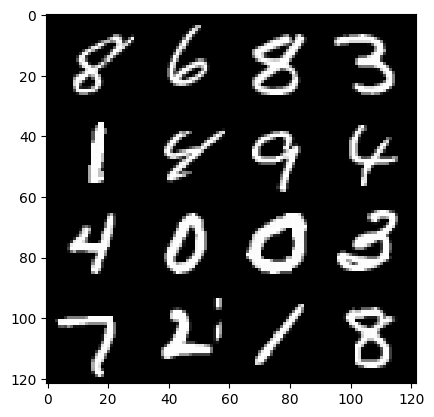

Epoch = 111 cur_step = 51590 disc_loss = 0.3307565498644355 gen_loss = 1.6665118061911577
Saving Checkpoint: 51700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 52875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

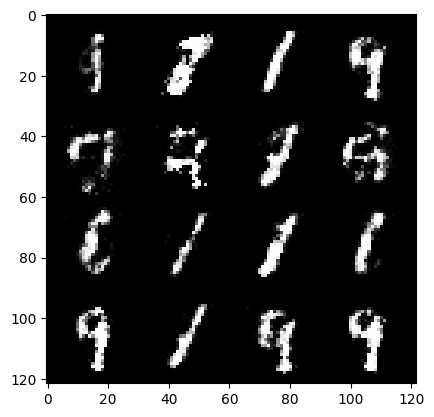

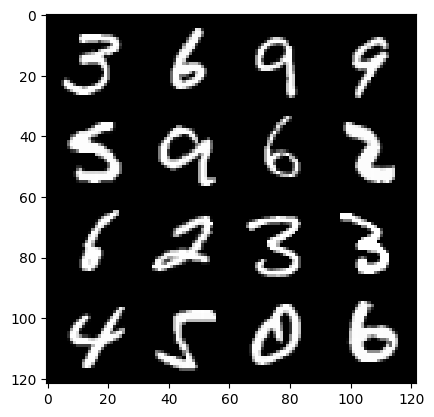

Epoch = 116 cur_step = 53935 disc_loss = 0.34687914456258706 gen_loss = 1.5828031489081473
Saving Checkpoint: 54050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 55225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

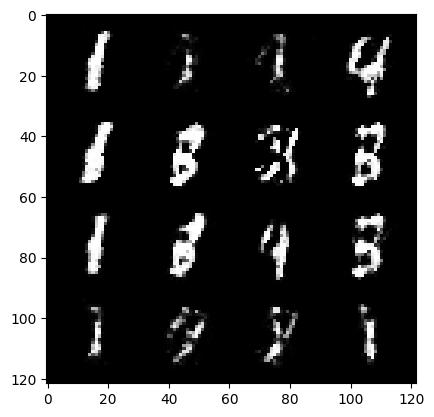

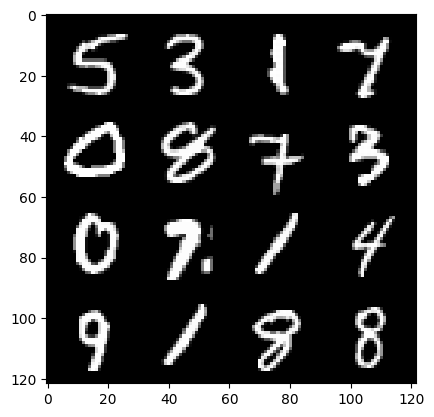

Epoch = 121 cur_step = 56280 disc_loss = 0.34564193982813657 gen_loss = 1.5794873701229786
Saving Checkpoint: 56400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 57575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

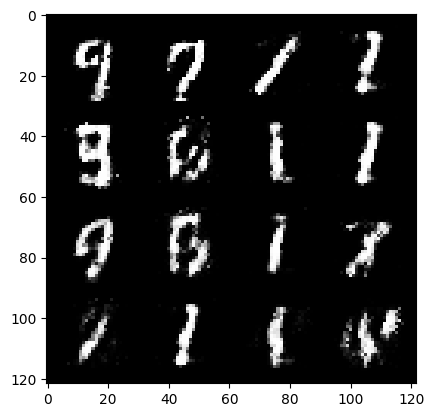

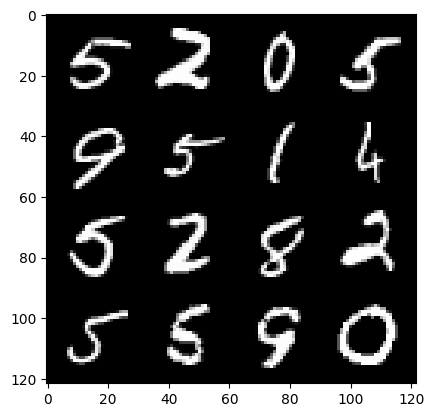

Epoch = 126 cur_step = 58625 disc_loss = 0.3400677668768714 gen_loss = 1.6032604751302235
Saving Checkpoint: 58750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 59925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

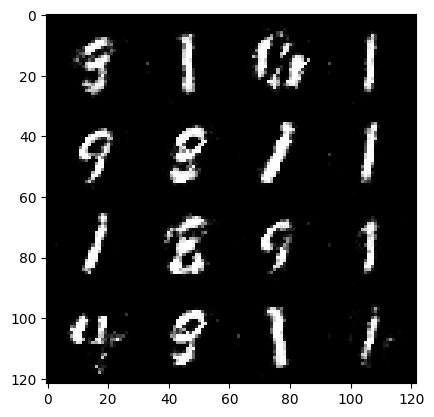

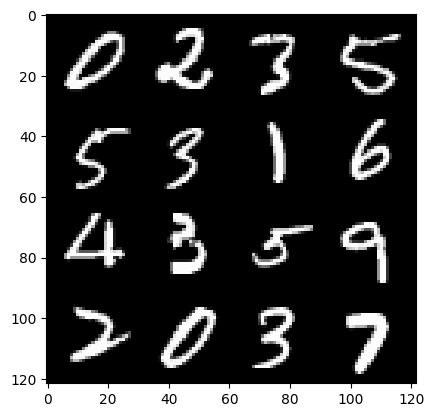

Epoch = 131 cur_step = 60970 disc_loss = 0.35322192923854917 gen_loss = 1.5759527678174505
Saving Checkpoint: 61100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 62275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

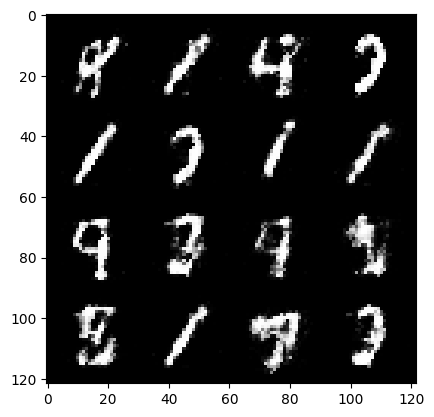

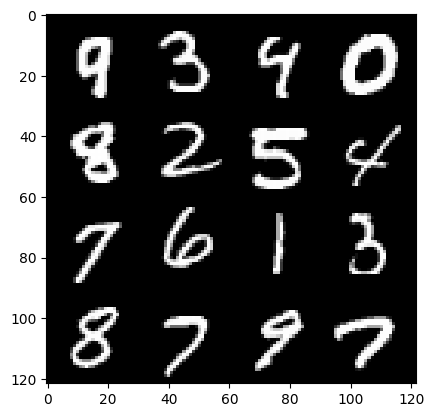

Epoch = 136 cur_step = 63315 disc_loss = 0.35523087884952775 gen_loss = 1.560887404443867
Saving Checkpoint: 63450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 64625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

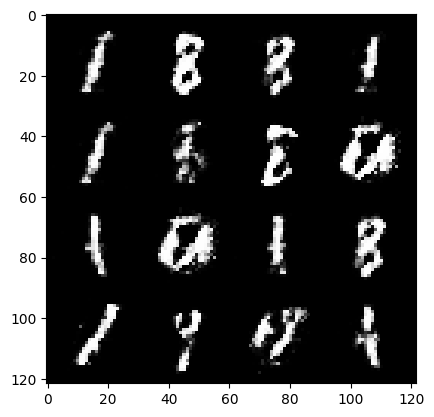

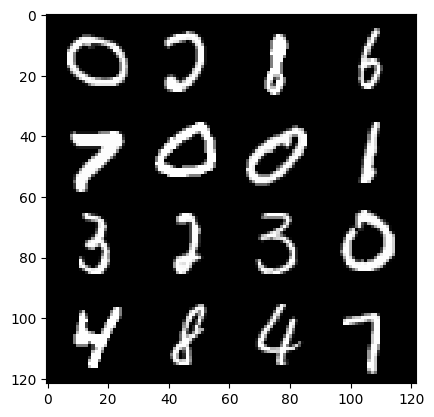

Epoch = 141 cur_step = 65660 disc_loss = 0.36627691623879904 gen_loss = 1.5169822973483154
Saving Checkpoint: 65800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 66975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

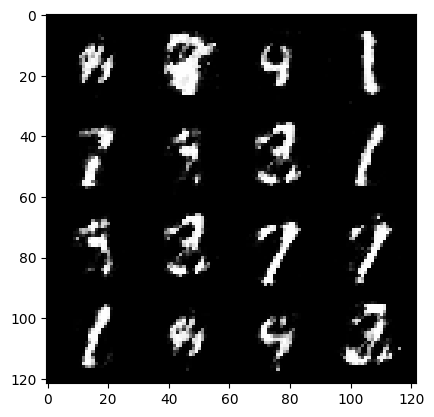

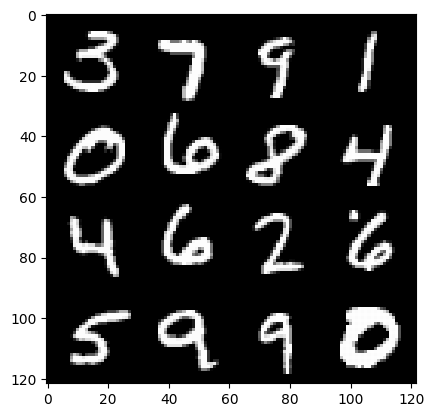

Epoch = 146 cur_step = 68005 disc_loss = 0.3784165679010501 gen_loss = 1.478205680948839
Saving Checkpoint: 68150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 69325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

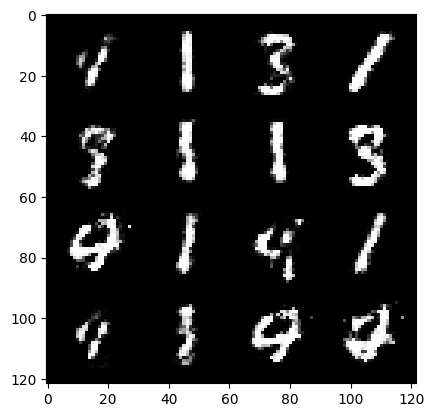

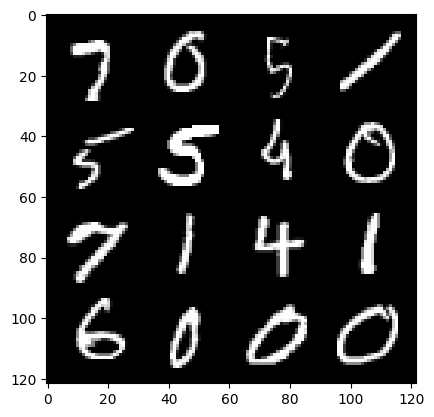

Epoch = 151 cur_step = 70350 disc_loss = 0.36540478120988873 gen_loss = 1.5325316414395884
Saving Checkpoint: 70500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 71675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

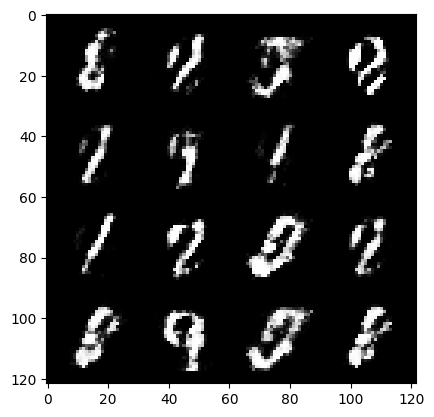

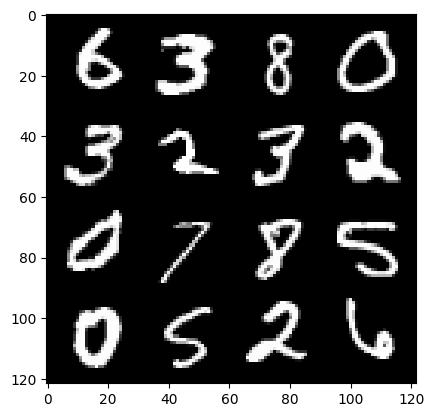

Epoch = 156 cur_step = 72695 disc_loss = 0.3594348831662237 gen_loss = 1.561197069255528
Saving Checkpoint: 72850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 74025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

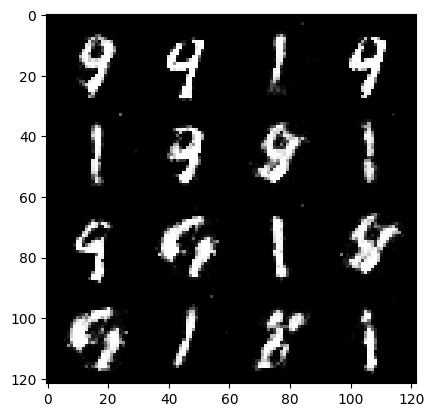

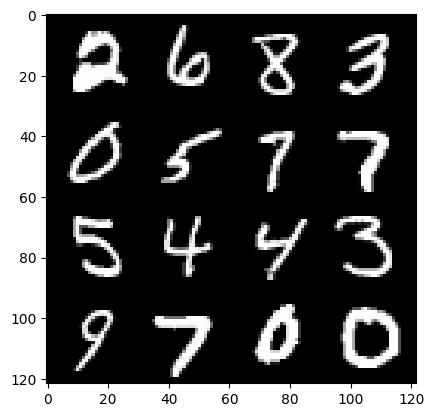

Epoch = 161 cur_step = 75040 disc_loss = 0.3508966036506299 gen_loss = 1.5712293646737203
Saving Checkpoint: 75200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 76375
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

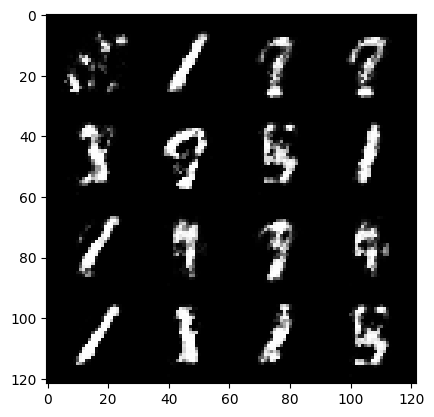

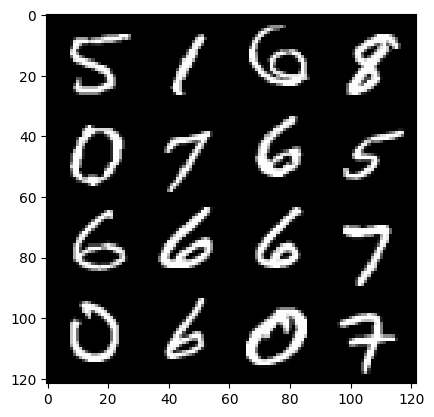

Epoch = 166 cur_step = 77385 disc_loss = 0.3830221139545888 gen_loss = 1.4880184715490605
Saving Checkpoint: 77550
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 78725
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

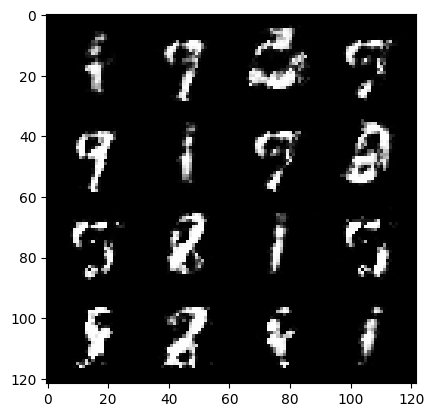

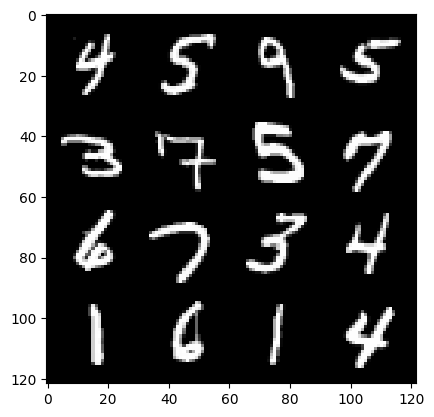

Epoch = 171 cur_step = 79730 disc_loss = 0.3645414063544162 gen_loss = 1.5391885545970534
Saving Checkpoint: 79900
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 81075
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

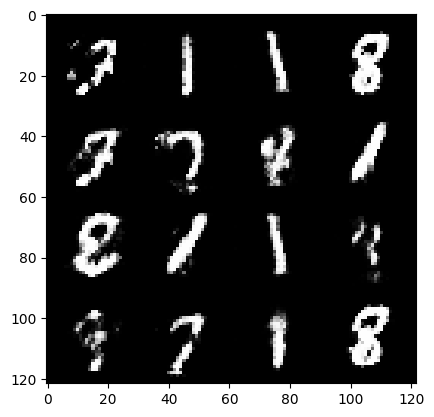

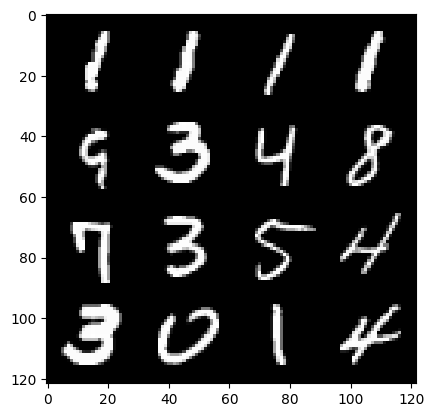

Epoch = 176 cur_step = 82075 disc_loss = 0.34269696018461987 gen_loss = 1.6305244035049797
Saving Checkpoint: 82250
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 83425
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

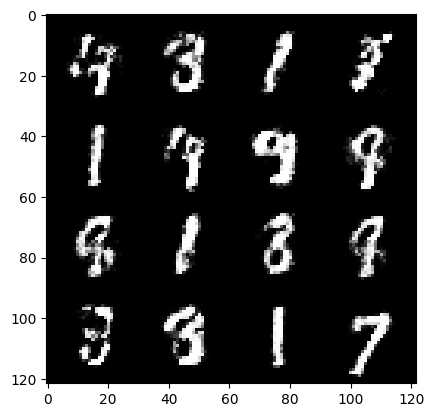

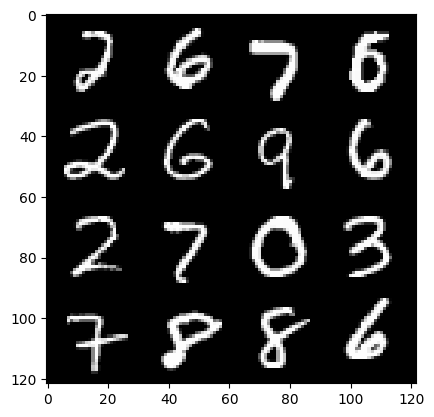

Epoch = 181 cur_step = 84420 disc_loss = 0.3977132379373254 gen_loss = 1.444217395426622
Saving Checkpoint: 84600
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 85775
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

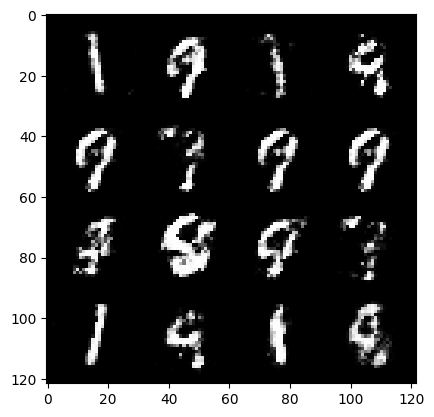

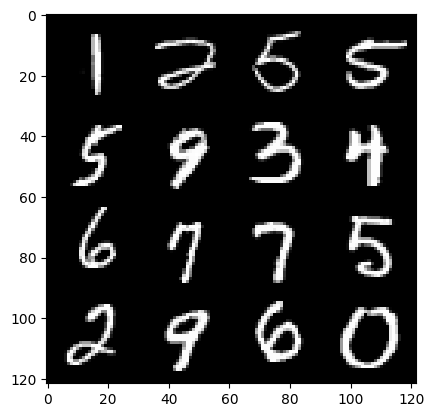

Epoch = 186 cur_step = 86765 disc_loss = 0.39919625619835436 gen_loss = 1.4283577637885934
Saving Checkpoint: 86950
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 88125
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

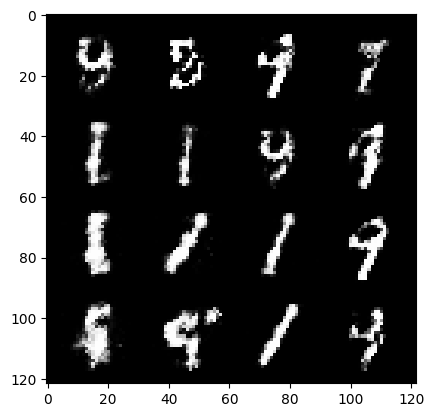

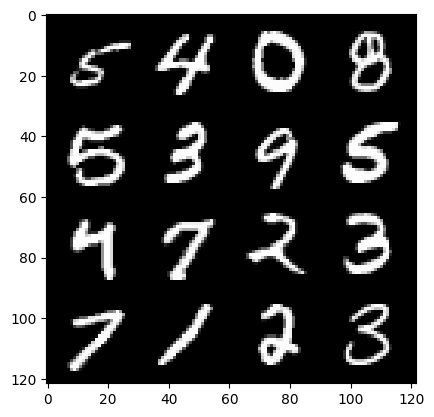

Epoch = 191 cur_step = 89110 disc_loss = 0.37423702181656476 gen_loss = 1.5163613493254444
Saving Checkpoint: 89300
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 90475
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

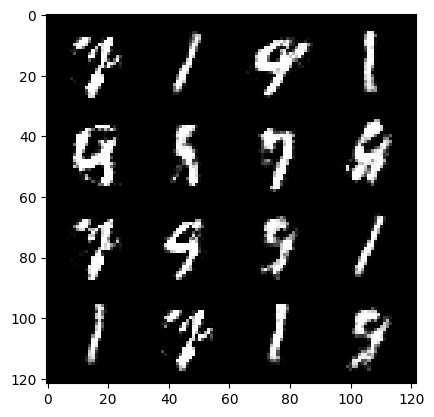

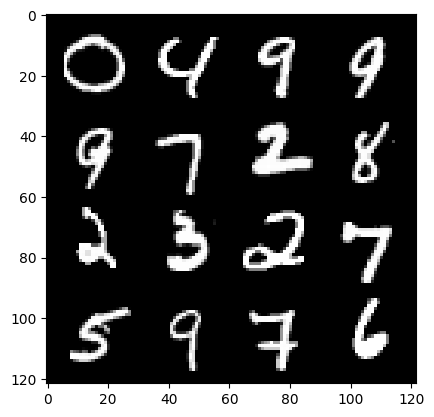

Epoch = 196 cur_step = 91455 disc_loss = 0.36340513681806225 gen_loss = 1.56033016461045
Saving Checkpoint: 91650
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 92825
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

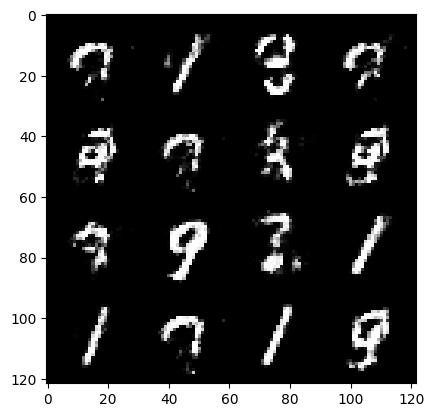

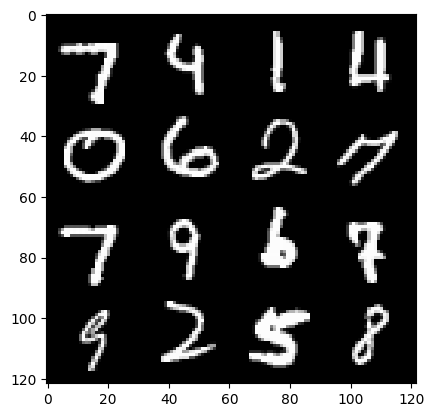

Epoch = 201 cur_step = 93800 disc_loss = 0.36455186286460617 gen_loss = 1.5746636245296455
Saving Checkpoint: 94000
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 95175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

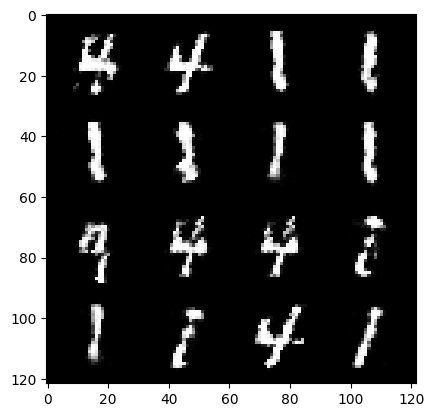

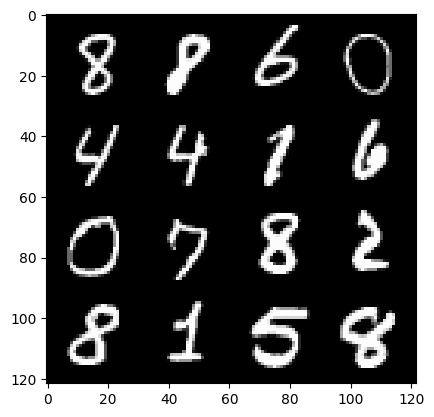

Epoch = 206 cur_step = 96145 disc_loss = 0.34128137033885475 gen_loss = 1.6730080625395785
Saving Checkpoint: 96350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 97525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

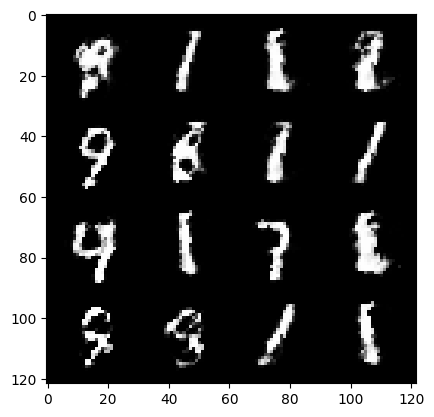

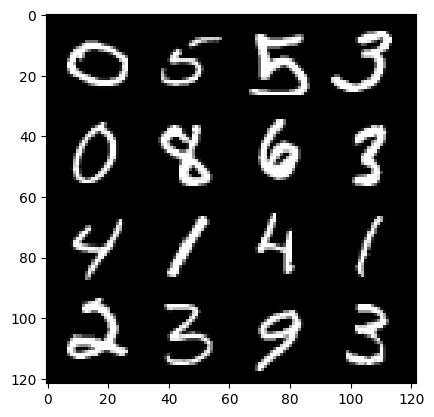

Epoch = 211 cur_step = 98490 disc_loss = 0.35999277340196595 gen_loss = 1.5923480070476084
Saving Checkpoint: 98700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 99875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

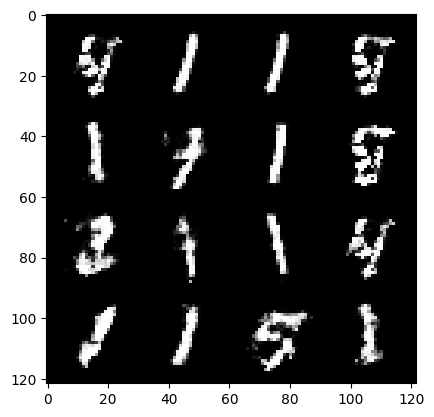

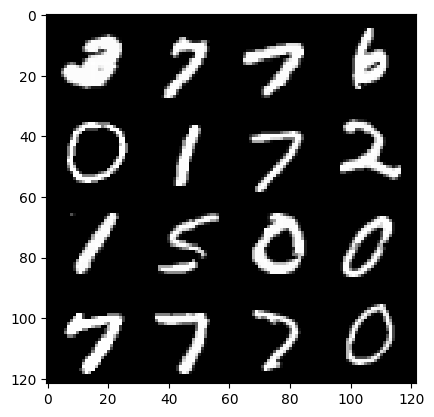

Epoch = 216 cur_step = 100835 disc_loss = 0.37440684562298787 gen_loss = 1.5348023303790388
Saving Checkpoint: 101050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 102225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

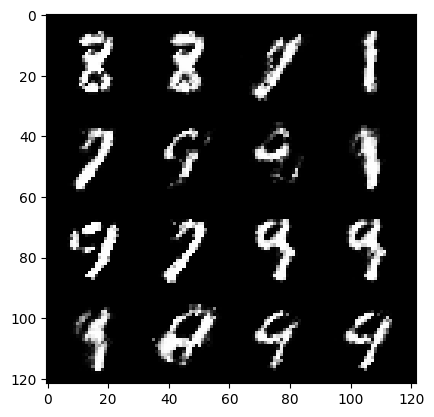

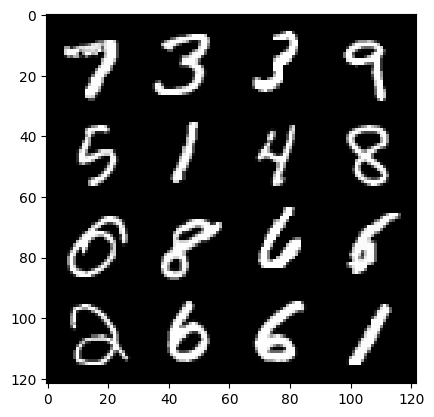

Epoch = 221 cur_step = 103180 disc_loss = 0.3723919318683112 gen_loss = 1.5457336669791737
Saving Checkpoint: 103400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 104575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

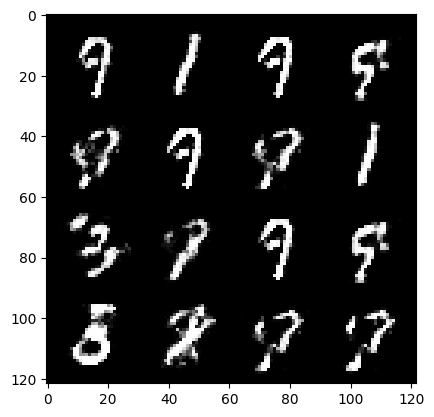

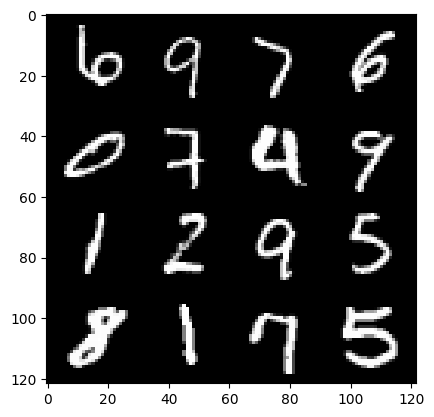

Epoch = 226 cur_step = 105525 disc_loss = 0.34790564703661747 gen_loss = 1.6192901025194604
Saving Checkpoint: 105750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 106925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

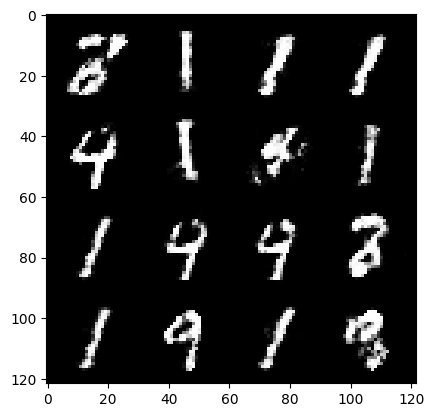

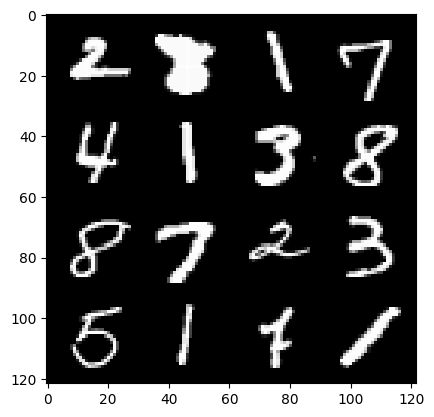

Epoch = 231 cur_step = 107870 disc_loss = 0.3560173695974513 gen_loss = 1.6067883625721882
Saving Checkpoint: 108100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 109275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

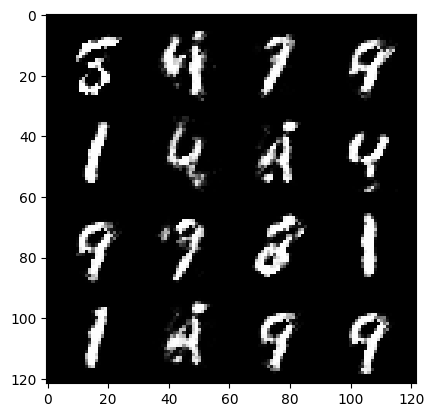

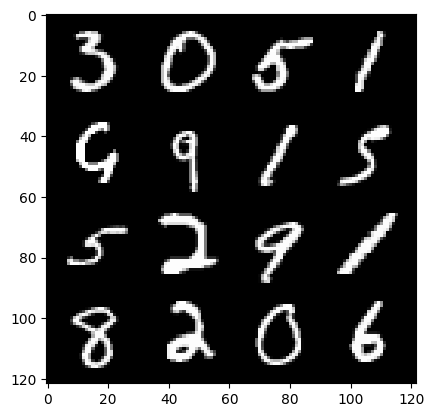

Epoch = 236 cur_step = 110215 disc_loss = 0.35384615210454856 gen_loss = 1.6185322374677353
Saving Checkpoint: 110450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 111625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

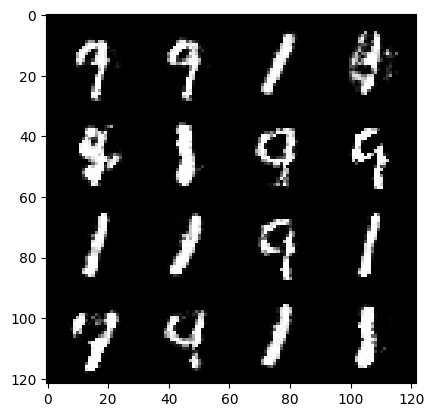

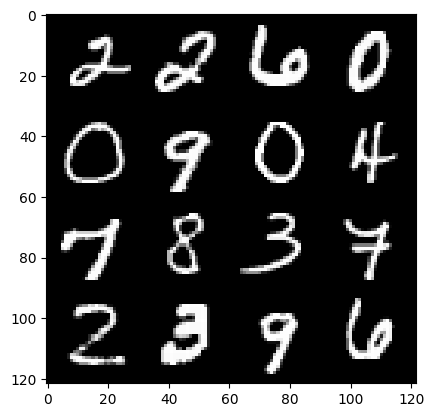

Epoch = 241 cur_step = 112560 disc_loss = 0.3531629181937622 gen_loss = 1.6387008497201558
Saving Checkpoint: 112800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 113975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

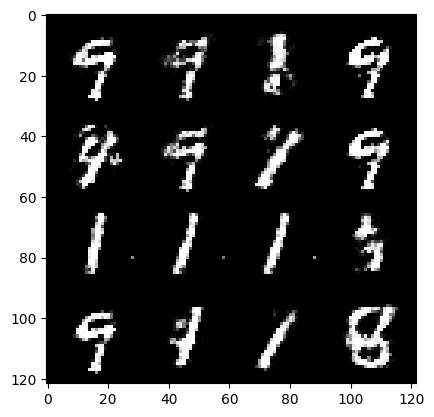

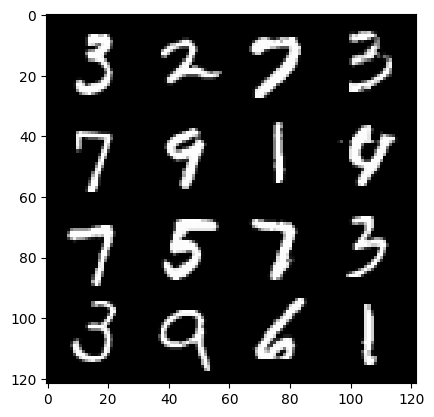

Epoch = 246 cur_step = 114905 disc_loss = 0.3591166051402529 gen_loss = 1.6022972107950304
Saving Checkpoint: 115150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 116325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

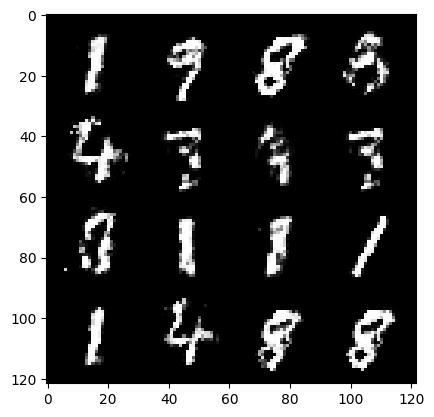

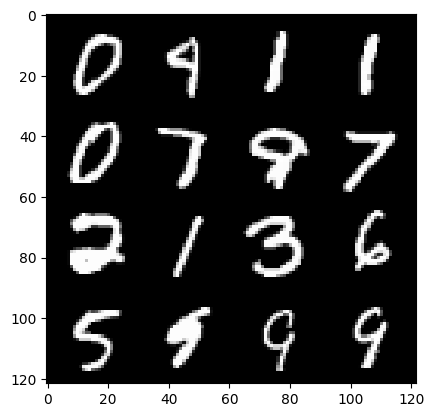

Epoch = 251 cur_step = 117250 disc_loss = 0.3590626509459034 gen_loss = 1.6087776691928855
Saving Checkpoint: 117500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 118675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

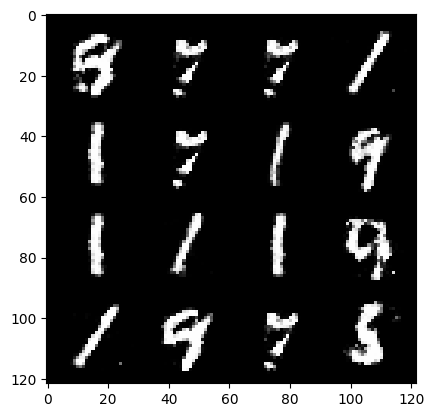

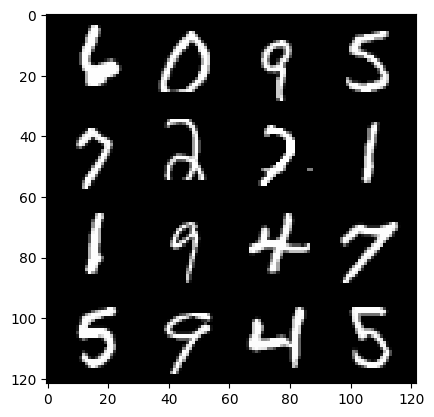

Epoch = 256 cur_step = 119595 disc_loss = 0.35027585348594925 gen_loss = 1.6451894673711456
Saving Checkpoint: 119850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 121025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

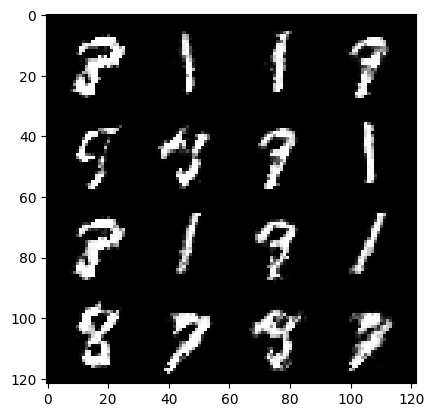

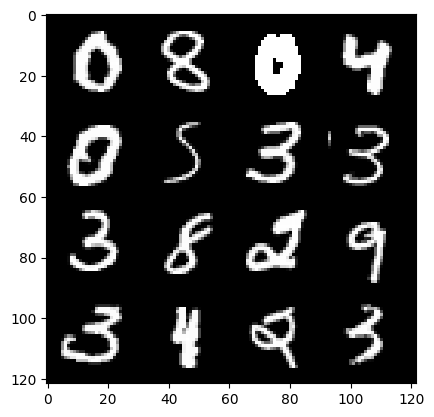

Epoch = 261 cur_step = 121940 disc_loss = 0.3615203989975488 gen_loss = 1.583366145050602
Saving Checkpoint: 122200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 123375
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

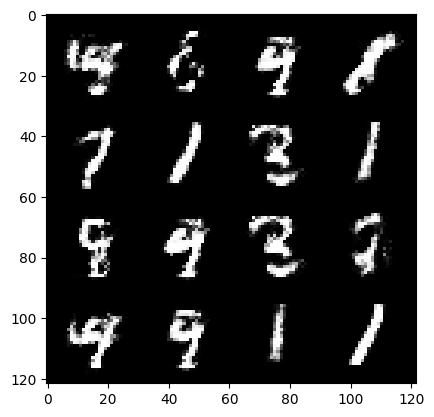

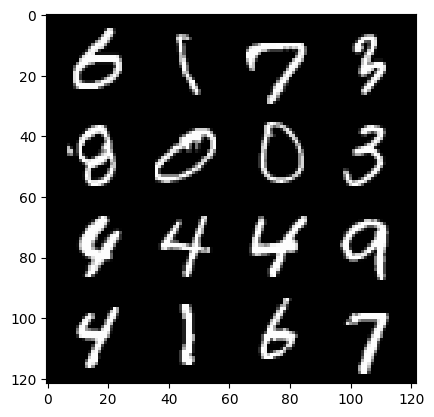

Epoch = 266 cur_step = 124285 disc_loss = 0.36590338895824165 gen_loss = 1.5974515885432392
Saving Checkpoint: 124550
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 125725
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

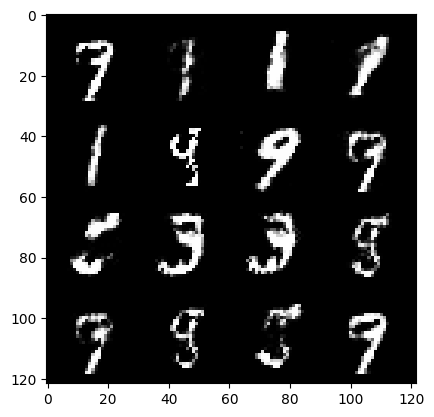

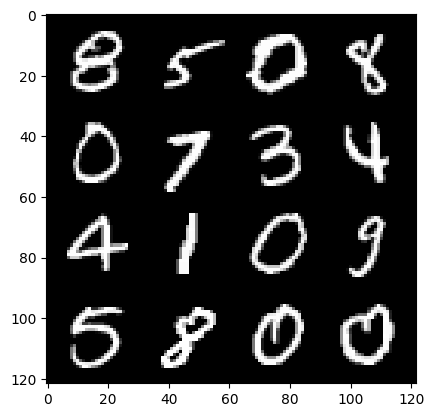

Epoch = 271 cur_step = 126630 disc_loss = 0.3516129007725827 gen_loss = 1.6555593412822243
Saving Checkpoint: 126900
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 128075
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

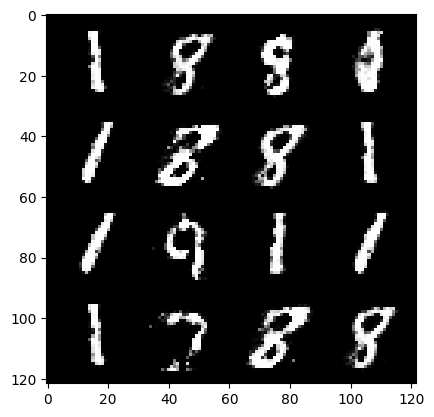

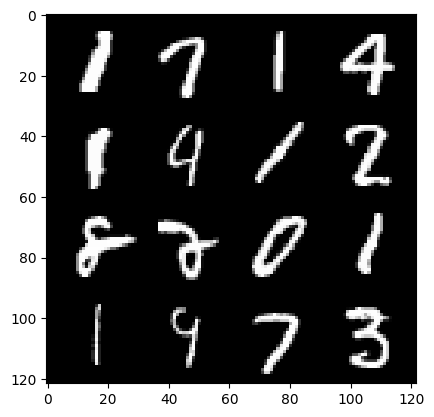

Epoch = 276 cur_step = 128975 disc_loss = 0.35129566847134247 gen_loss = 1.649516782933461
Saving Checkpoint: 129250
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 130425
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

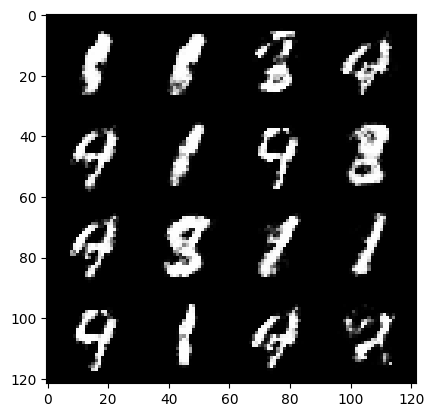

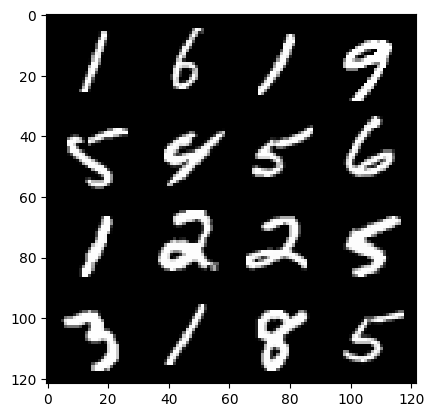

Epoch = 281 cur_step = 131320 disc_loss = 0.3589140105412713 gen_loss = 1.6153243678465072
Saving Checkpoint: 131600
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 132775
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

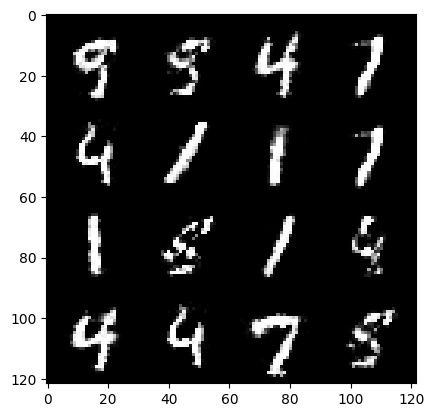

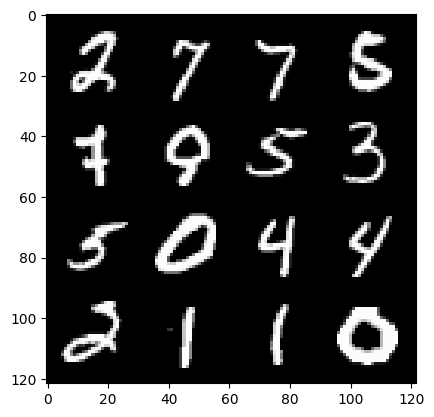

Epoch = 286 cur_step = 133665 disc_loss = 0.35909327438264005 gen_loss = 1.610096005437725
Saving Checkpoint: 133950
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 135125
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

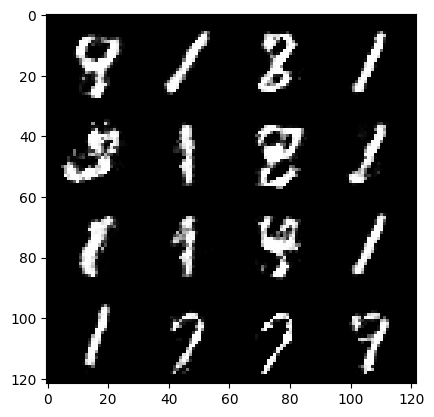

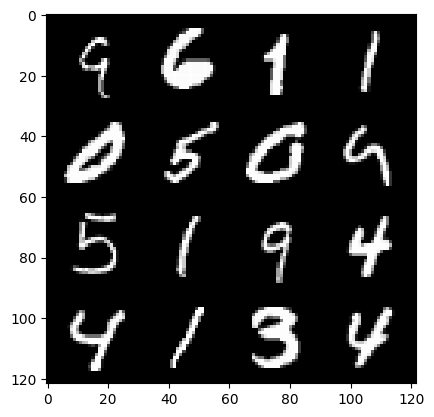

Epoch = 291 cur_step = 136010 disc_loss = 0.3473110155128975 gen_loss = 1.6756314995954795
Saving Checkpoint: 136300
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 137475
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

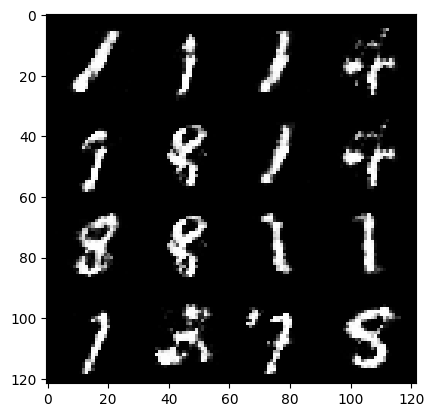

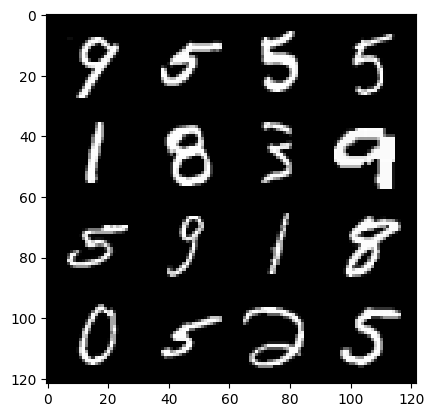

Epoch = 296 cur_step = 138355 disc_loss = 0.34145004727057554 gen_loss = 1.6740949968285144
Saving Checkpoint: 138650
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 139825
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

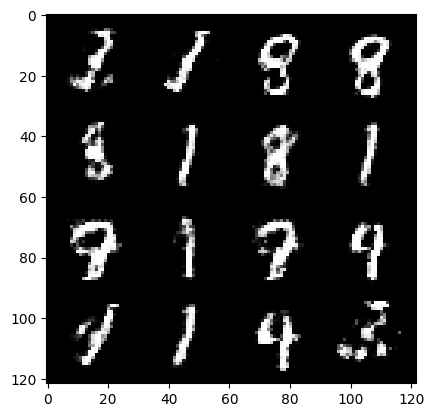

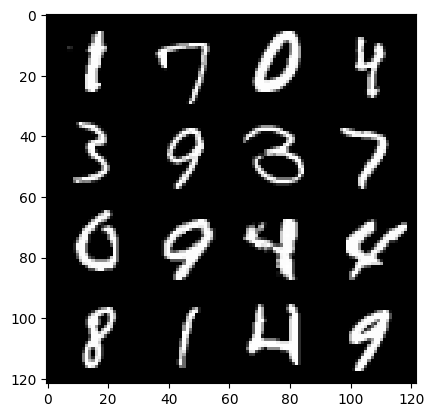

Epoch = 301 cur_step = 140700 disc_loss = 0.33606172004488233 gen_loss = 1.7048685647785538
Saving Checkpoint: 141000
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 142175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

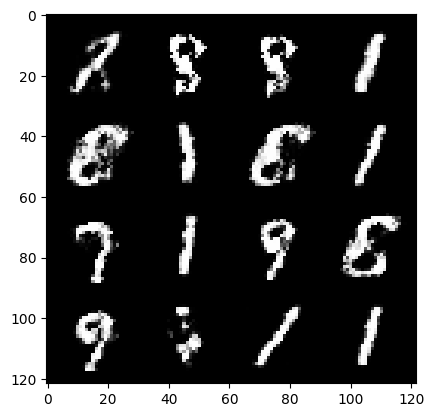

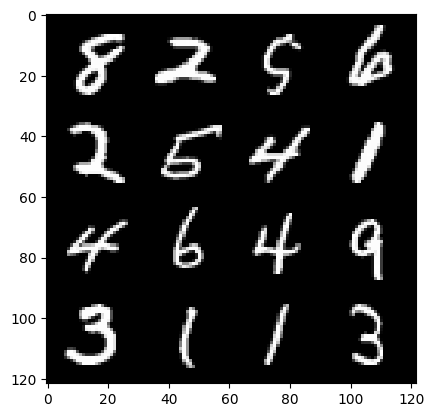

Epoch = 306 cur_step = 143045 disc_loss = 0.3325191252902627 gen_loss = 1.7184377042469439
Saving Checkpoint: 143350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 144525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

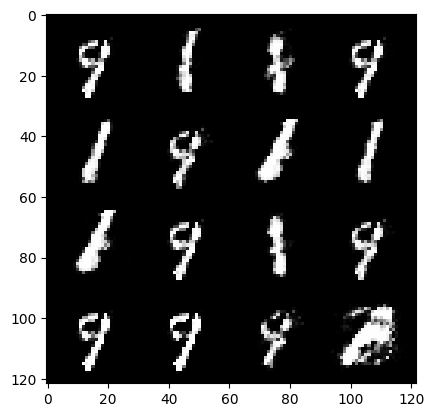

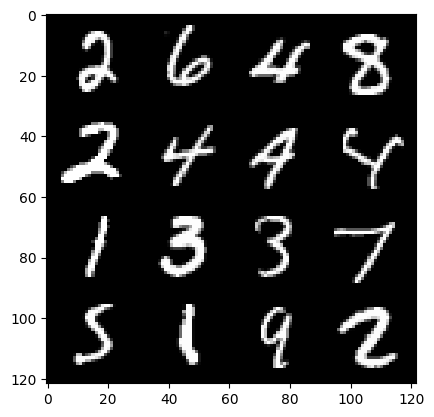

Epoch = 311 cur_step = 145390 disc_loss = 0.33714275731842147 gen_loss = 1.7017223783139226
Saving Checkpoint: 145700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 146875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

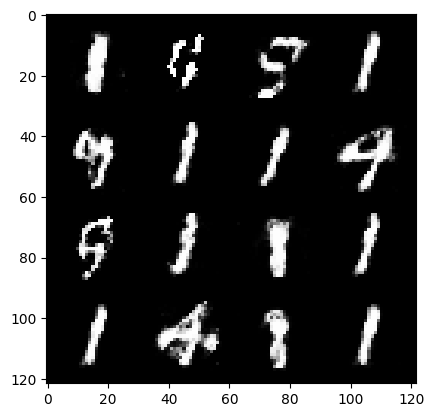

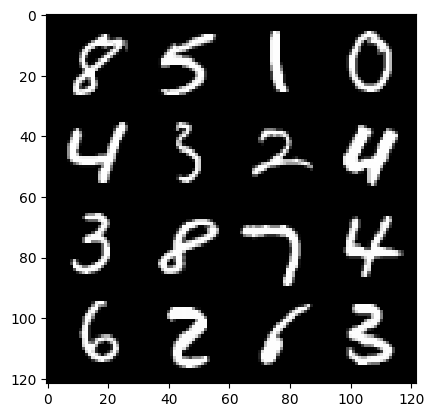

Epoch = 316 cur_step = 147735 disc_loss = 0.34117893547391587 gen_loss = 1.707039071552789
Saving Checkpoint: 148050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 149225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

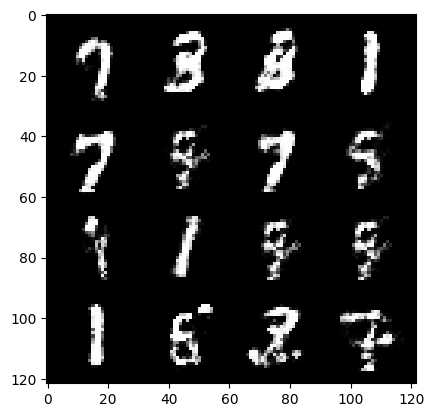

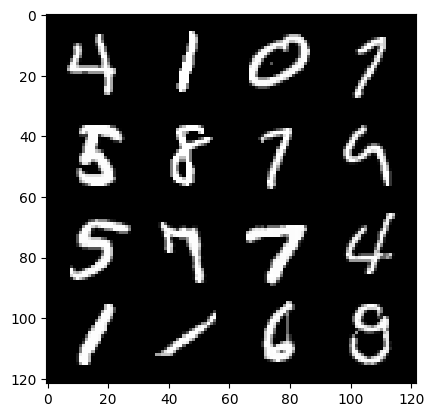

Epoch = 321 cur_step = 150080 disc_loss = 0.336679561070796 gen_loss = 1.7340234534318513
Saving Checkpoint: 150400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 151575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

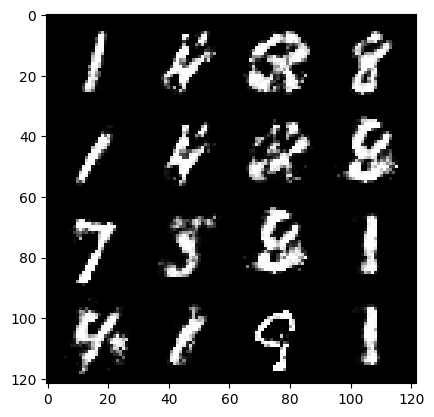

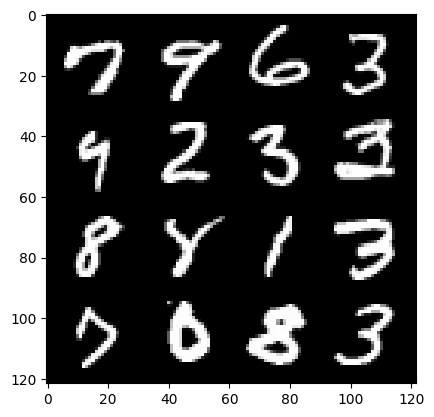

Epoch = 326 cur_step = 152425 disc_loss = 0.3334984257658407 gen_loss = 1.7148337815616177
Saving Checkpoint: 152750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 153925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

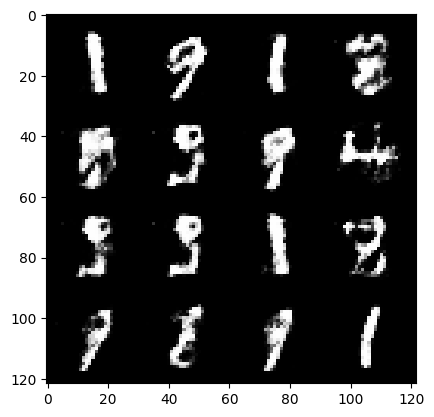

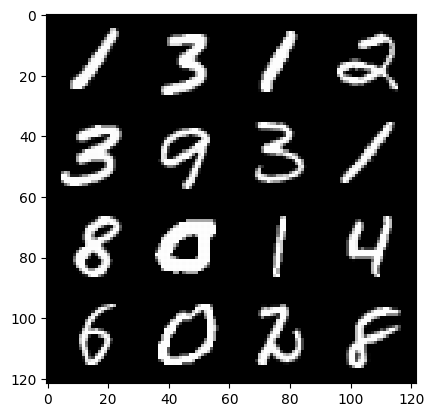

Epoch = 331 cur_step = 154770 disc_loss = 0.36114706183547407 gen_loss = 1.6030794329226399
Saving Checkpoint: 155100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 156275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

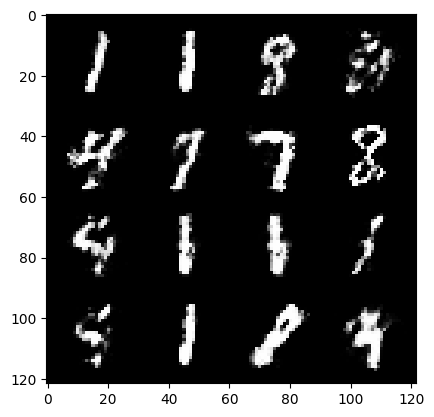

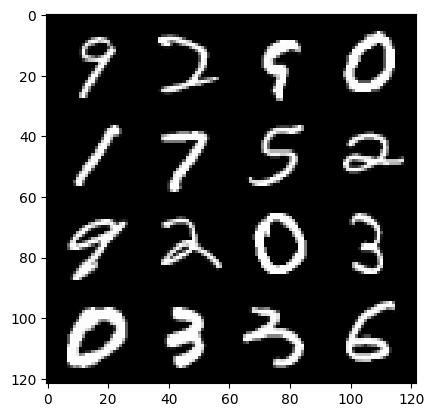

Epoch = 336 cur_step = 157115 disc_loss = 0.3183291632991864 gen_loss = 1.7786340888883514
Saving Checkpoint: 157450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 158625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

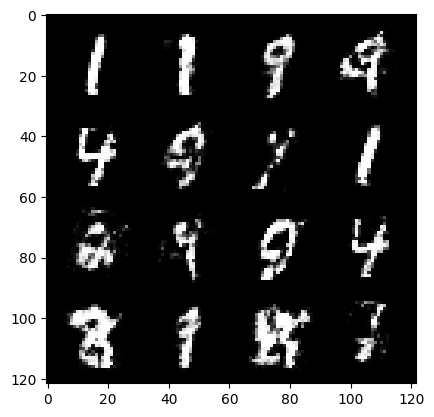

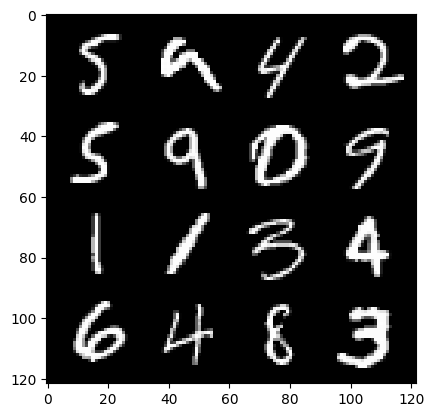

Epoch = 341 cur_step = 159460 disc_loss = 0.32292649855237526 gen_loss = 1.7463689549391204
Saving Checkpoint: 159800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 160975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

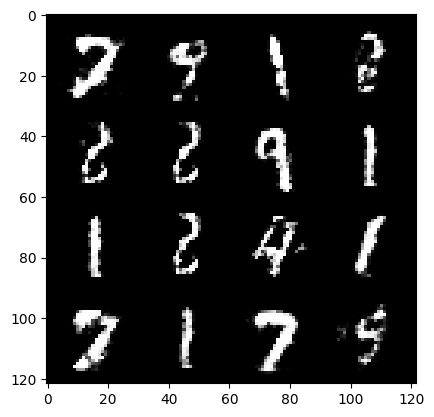

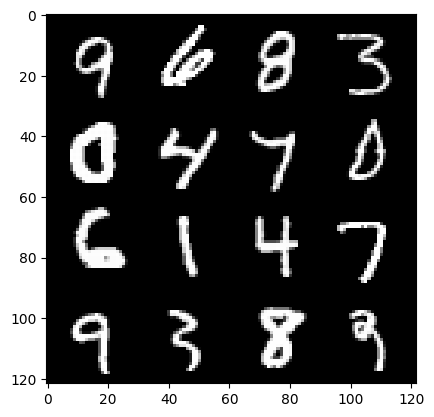

Epoch = 346 cur_step = 161805 disc_loss = 0.3431337414011518 gen_loss = 1.6606507692255699
Saving Checkpoint: 162150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 163325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

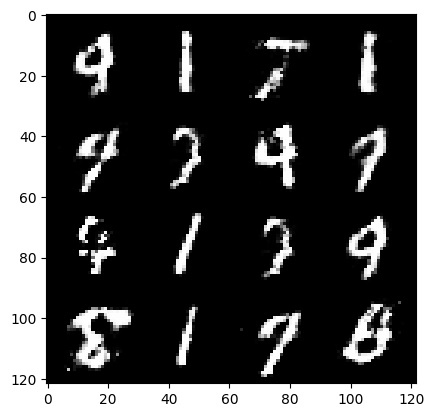

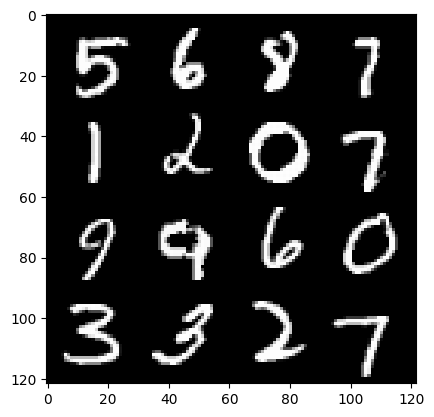

Epoch = 351 cur_step = 164150 disc_loss = 0.34166759281143194 gen_loss = 1.6745435309562602
Saving Checkpoint: 164500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 165675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

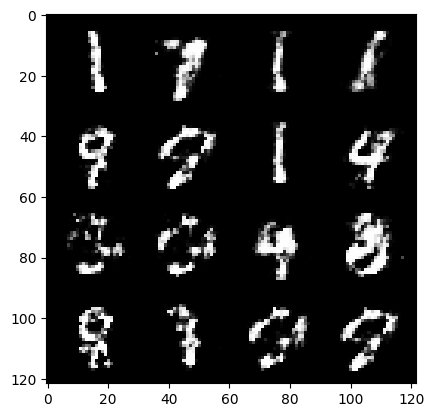

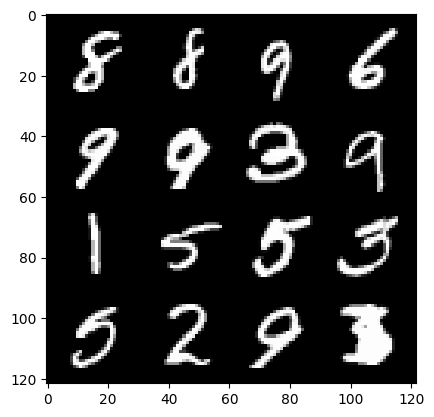

Epoch = 356 cur_step = 166495 disc_loss = 0.36837404570472776 gen_loss = 1.5672920732864184
Saving Checkpoint: 166850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 168025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

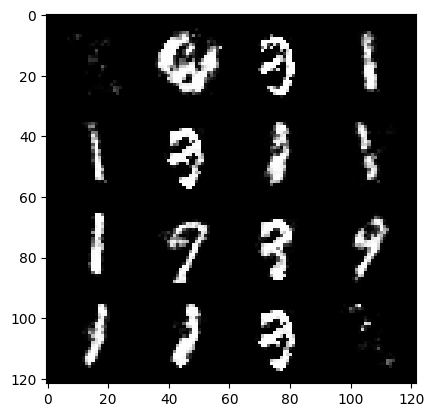

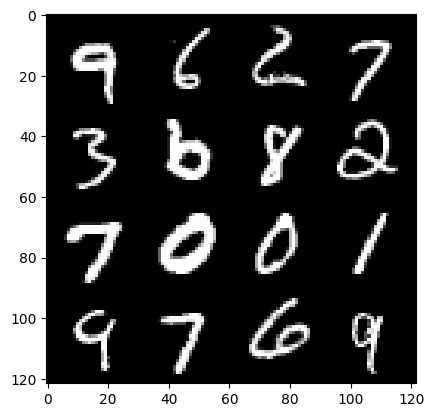

Epoch = 361 cur_step = 168840 disc_loss = 0.36694394617573795 gen_loss = 1.574589722446287
Saving Checkpoint: 169200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 170375
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

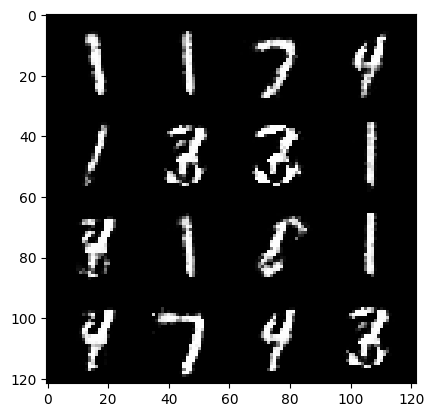

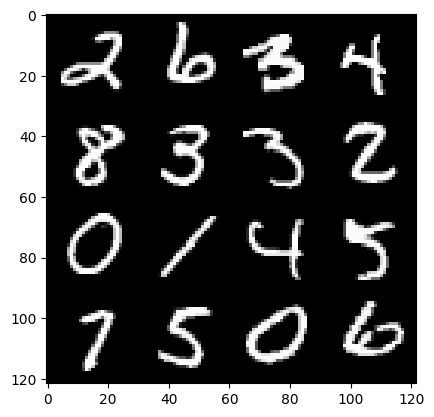

Epoch = 366 cur_step = 171185 disc_loss = 0.37049724520650756 gen_loss = 1.543467042746066
Saving Checkpoint: 171550
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 172725
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

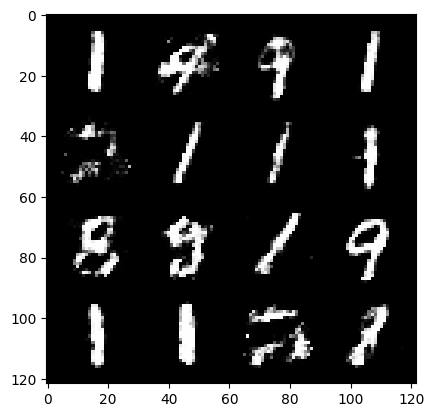

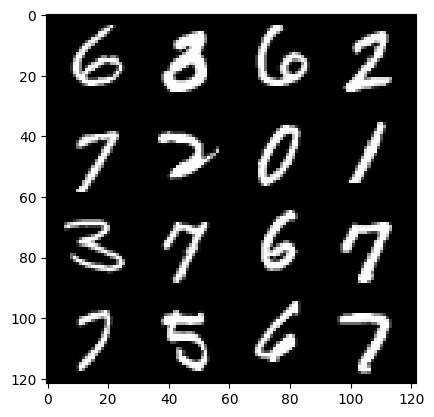

Epoch = 371 cur_step = 173530 disc_loss = 0.36144100707858356 gen_loss = 1.6039588816892871
Saving Checkpoint: 173900
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 175075
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

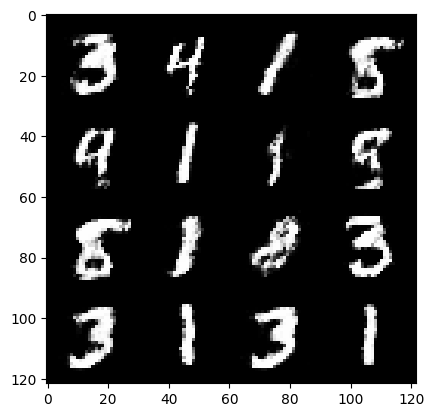

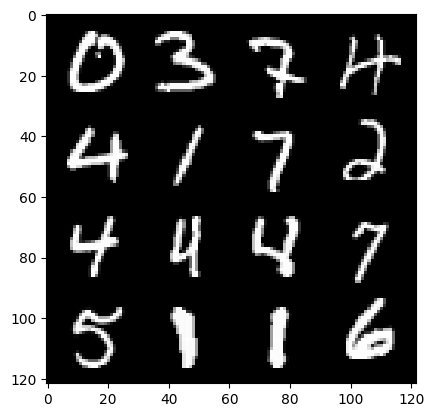

Epoch = 376 cur_step = 175875 disc_loss = 0.36134846636862644 gen_loss = 1.5888842825188056
Saving Checkpoint: 176250
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 177425
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

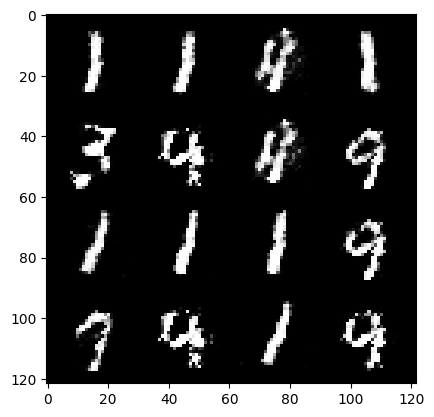

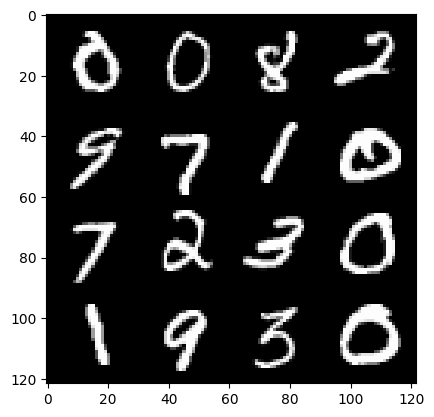

Epoch = 381 cur_step = 178220 disc_loss = 0.3512915669982113 gen_loss = 1.6268442019724896
Saving Checkpoint: 178600
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 179775
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

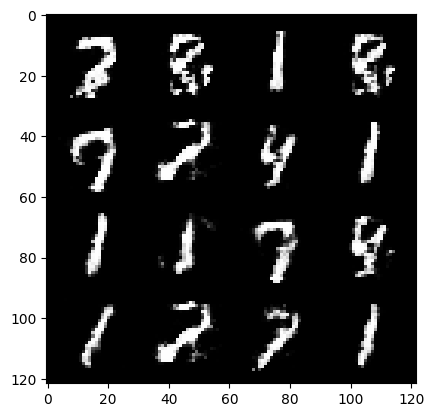

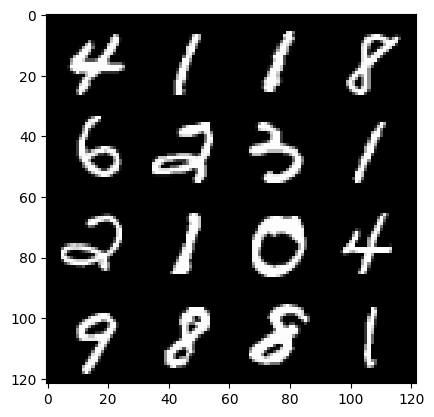

Epoch = 386 cur_step = 180565 disc_loss = 0.3624537337690528 gen_loss = 1.5858489632352328
Saving Checkpoint: 180950
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 182125
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

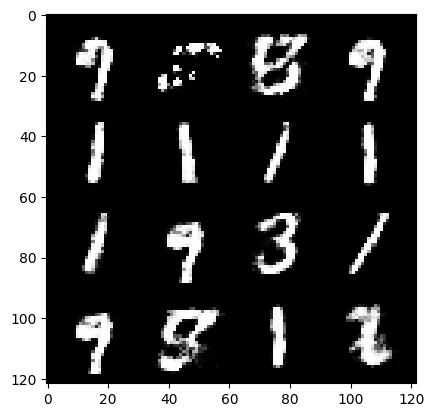

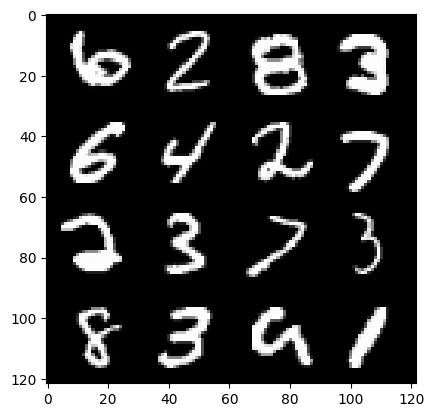

Epoch = 391 cur_step = 182910 disc_loss = 0.36224705319541856 gen_loss = 1.5636212734779569
Saving Checkpoint: 183300
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 184475
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

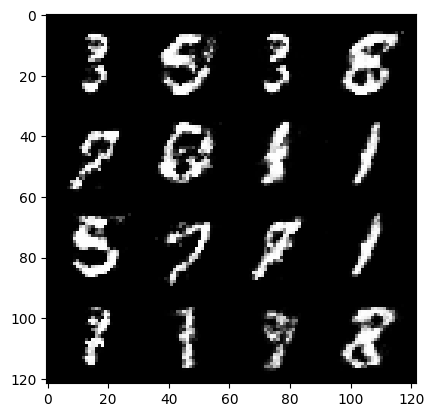

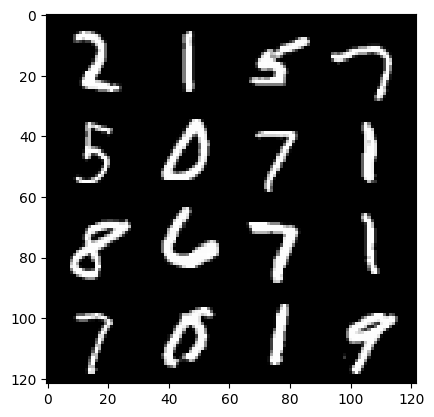

Epoch = 396 cur_step = 185255 disc_loss = 0.3724125335592705 gen_loss = 1.5516012619299167
Saving Checkpoint: 185650
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 186825
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

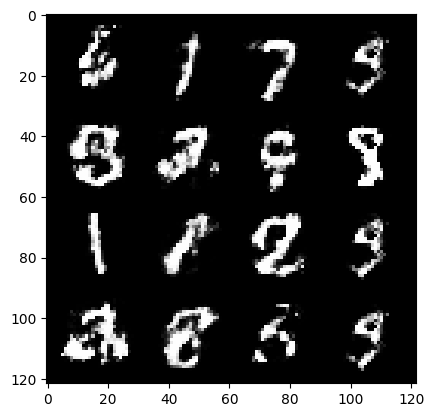

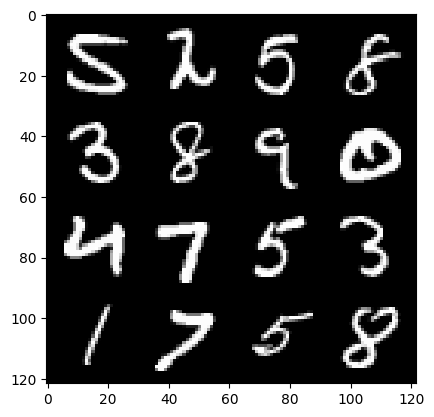

Epoch = 401 cur_step = 187600 disc_loss = 0.395104071091233 gen_loss = 1.4732353191131722
Saving Checkpoint: 188000
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 189175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

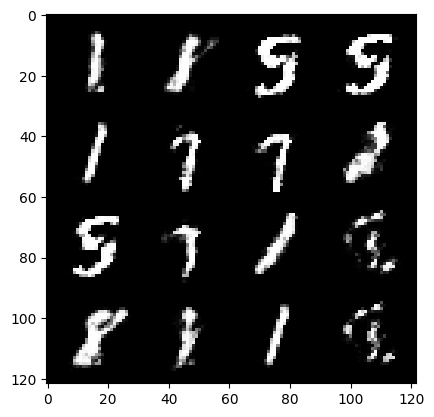

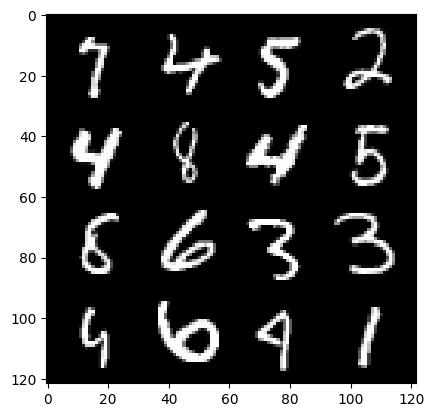

Epoch = 406 cur_step = 189945 disc_loss = 0.39007245186549516 gen_loss = 1.5009567404098347
Saving Checkpoint: 190350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 191525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

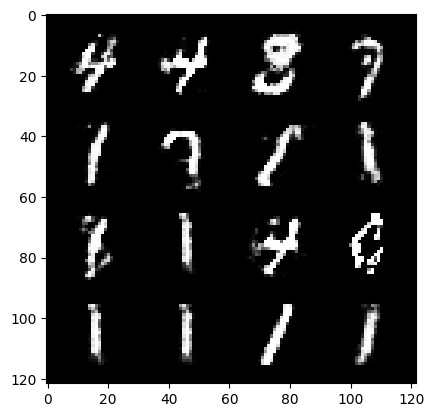

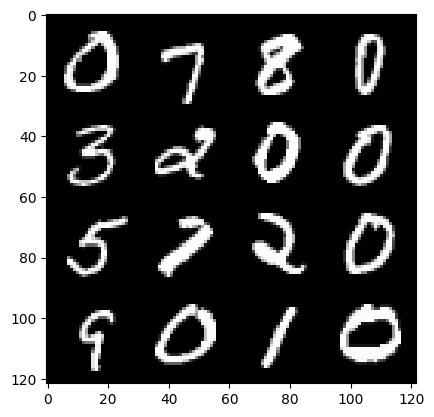

Epoch = 411 cur_step = 192290 disc_loss = 0.3562422991497939 gen_loss = 1.5938376830839145
Saving Checkpoint: 192700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 193875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

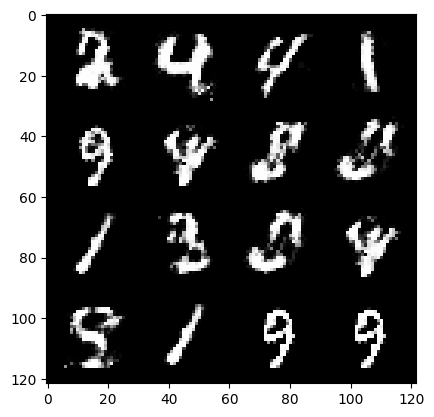

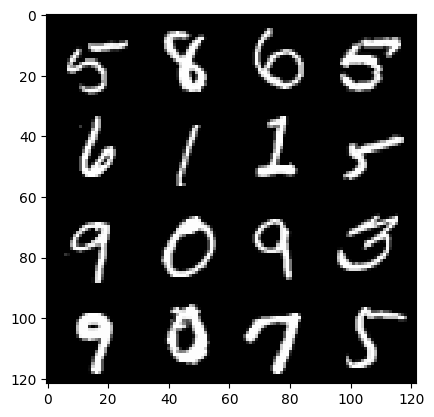

Epoch = 416 cur_step = 194635 disc_loss = 0.3812702707517376 gen_loss = 1.5154133363064926
Saving Checkpoint: 195050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 196225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

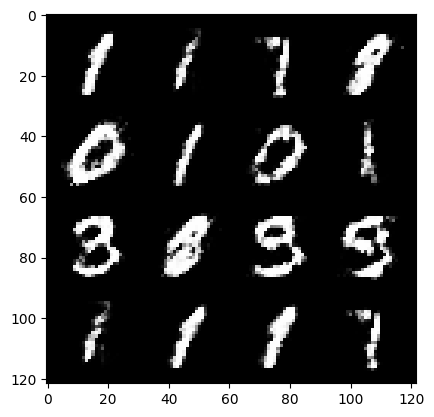

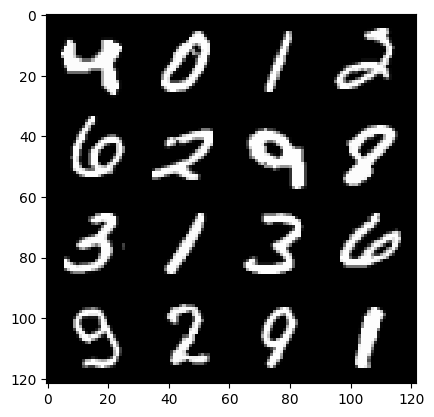

Epoch = 421 cur_step = 196980 disc_loss = 0.3921514554064411 gen_loss = 1.4728515863926934
Saving Checkpoint: 197400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 198575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

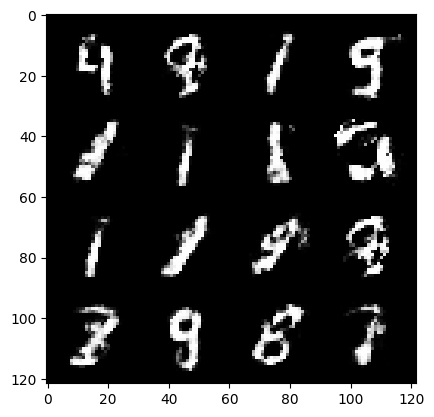

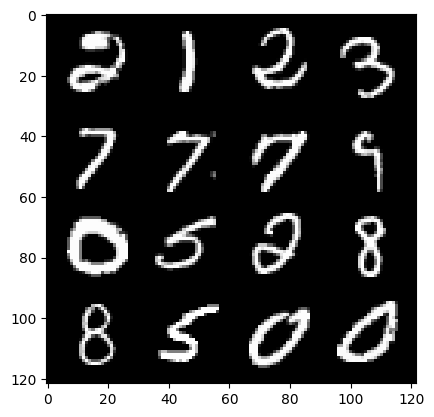

Epoch = 426 cur_step = 199325 disc_loss = 0.39207495743277737 gen_loss = 1.4836871285936726
Saving Checkpoint: 199750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 200925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

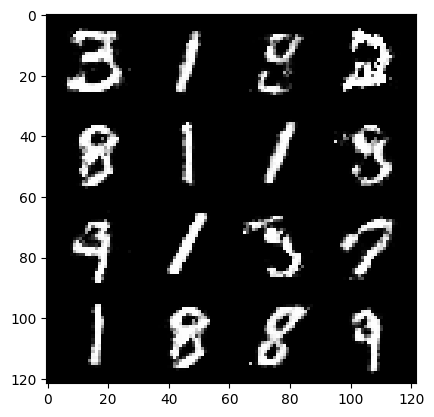

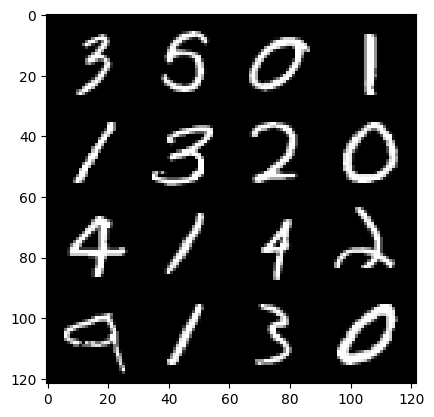

Epoch = 431 cur_step = 201670 disc_loss = 0.37667730501465707 gen_loss = 1.5380560710231888
Saving Checkpoint: 202100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 203275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

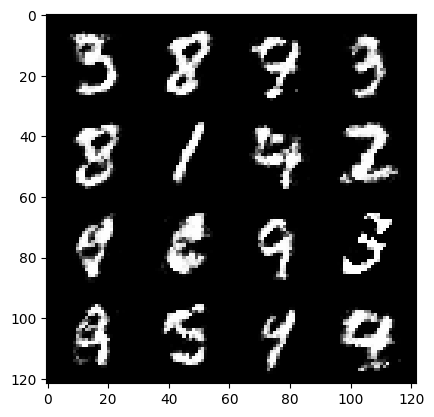

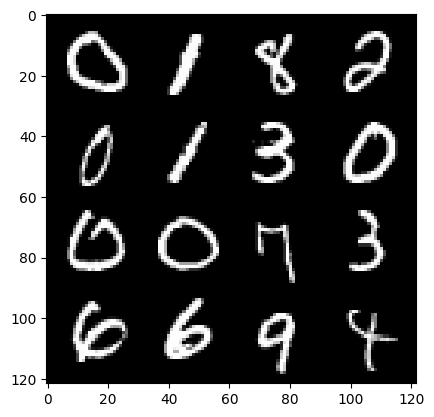

Epoch = 436 cur_step = 204015 disc_loss = 0.37987093653506054 gen_loss = 1.5250078961793294
Saving Checkpoint: 204450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 205625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

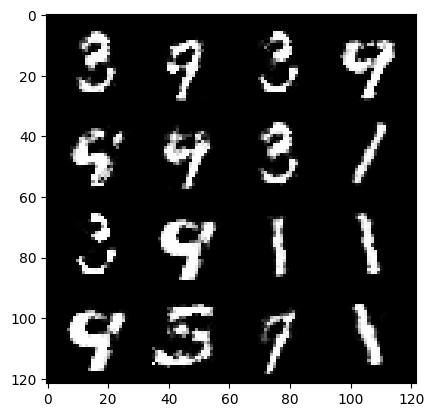

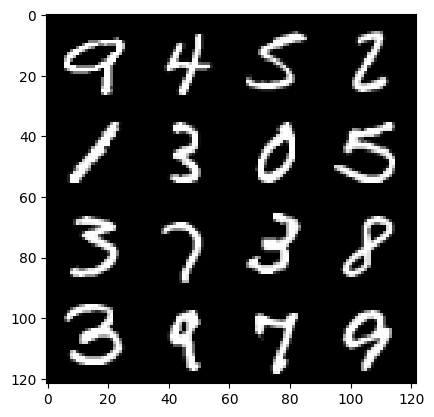

Epoch = 441 cur_step = 206360 disc_loss = 0.414407326964173 gen_loss = 1.40758406449991
Saving Checkpoint: 206800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 207975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

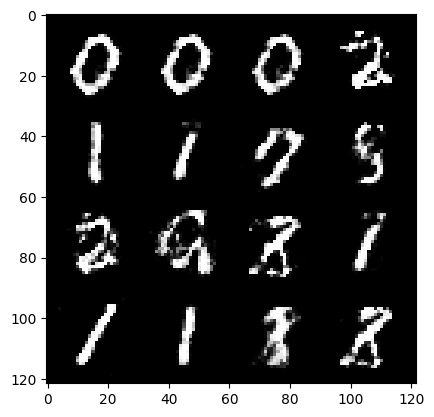

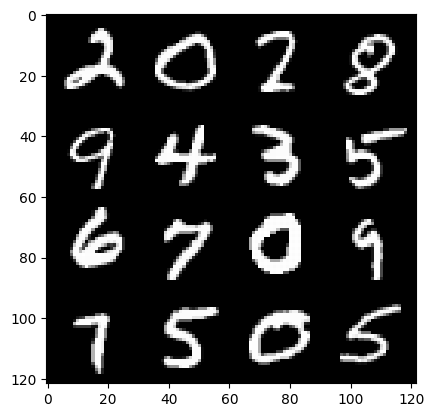

Epoch = 446 cur_step = 208705 disc_loss = 0.3963381697882467 gen_loss = 1.4748682056662878
Saving Checkpoint: 209150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 210325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

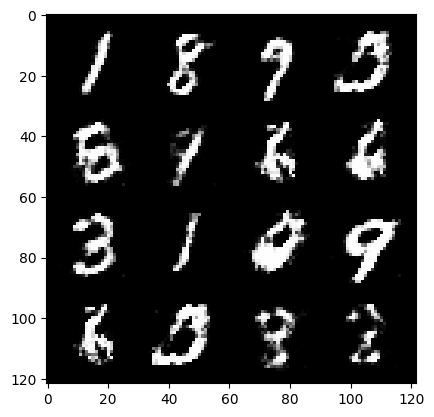

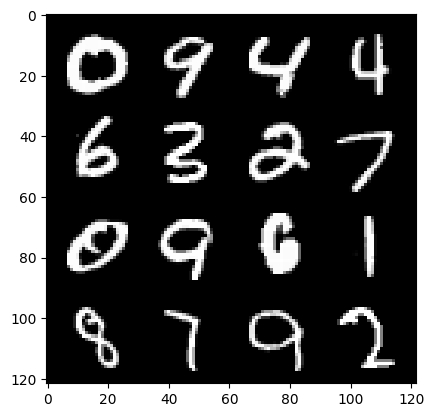

Epoch = 451 cur_step = 211050 disc_loss = 0.39236799603077904 gen_loss = 1.4816040100573478
Saving Checkpoint: 211500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 212675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

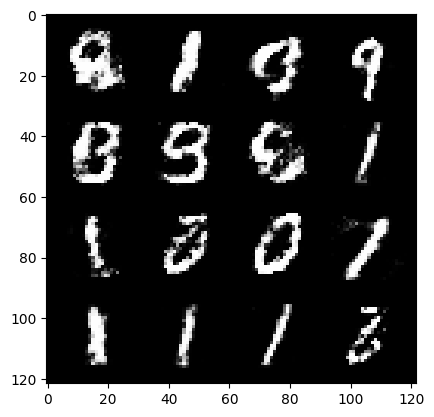

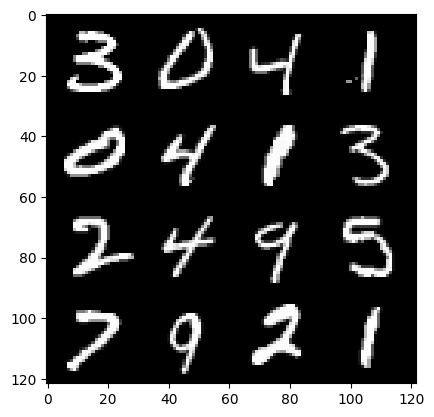

Epoch = 456 cur_step = 213395 disc_loss = 0.4014835094338033 gen_loss = 1.4564584795600062
Saving Checkpoint: 213850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 215025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

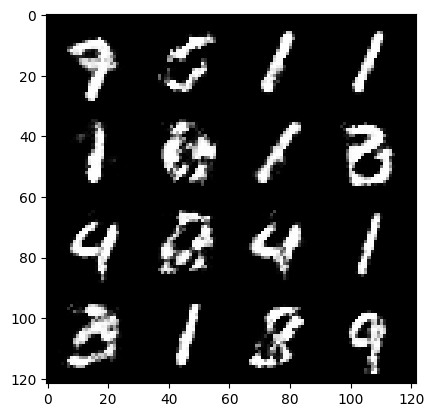

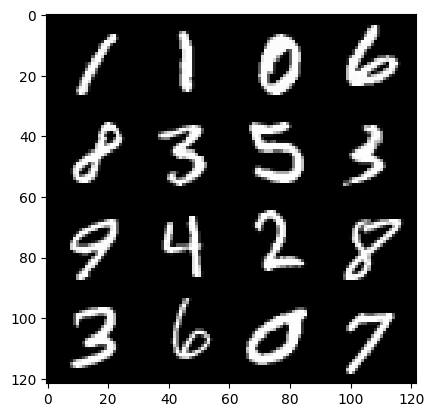

Epoch = 461 cur_step = 215740 disc_loss = 0.3975377605477376 gen_loss = 1.4635340208183727
Saving Checkpoint: 216200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"

for epoch in range(1006, epochs+1006):
    for real_img, labels in tqdm(dataloader):

        cur_bs = len(real_img)
        real_img = real_img.view(cur_bs, -1)

        ### Discrimnator
        disc_opt.zero_grad()
        real_img = real_img.to(device)

        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real_img, z_dim)

        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        ### Generator
        gen_opt.zero_grad()

        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)

        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        ### visualisation & stats
        mean_disc_loss += disc_loss.item()
        mean_gen_loss += gen_loss.item()

        if cur_step % info_step == 0 and cur_step > 0:
            fake_noise = gen_noise( cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake, wandbactive=1 , name='fake')
            show(real_img, wandbactive=1 , name='real')
            print("Epoch =",epoch,"cur_step =",cur_step, "disc_loss =",mean_disc_loss/info_step, "gen_loss =",mean_gen_loss/info_step  )
            mean_gen_loss = 0
            mean_disc_loss = 0

        if cur_step % save_steps == 0 and cur_step > 0:
            print("Saving Checkpoint:", cur_step)
            save_checkpoint("NumGEN-MNIST", save_path)

        if wandbact == 1:
            wandb.log({'Epoch' : epoch, 'Step' : cur_step, "Critic_Loss" : disc_loss, "Gen_Loss" : gen_loss })

        cur_step += 1

In [1]:

save_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"
save_checkpoint("NumGEN-MNIST", save_path)

NameError: name 'save_checkpoint' is not defined